In [1]:
import numpy as np
import sklearn
import pandas as pd
import csv
from sklearn.model_selection import train_test_split
from sklearn import  ensemble, preprocessing, metrics
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import os
import seaborn as sns
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import cross_validate

## 資料讀取與前處理

In [2]:
#讀取資料 資料需要依據label進行分檔
path = "D:/HC/博士班課程/林醫師/二次中風/男女分開/男/"
normal = pd.read_csv(path+"N7.csv")
block = pd.read_csv(path+"Y.csv")
#data = pd.read_csv(path+"After smote.csv")
data = pd.concat([block, normal], axis=0)

In [3]:
data

Second_Stroke  age  sex  HLOS  NIHSS  tPA(0/1)  EVT(0/1)  HTN(0/1)  \
0               1   59    0     6      0         0         0         0   
1               1   59    0     7      0         0         0         0   
2               1   74    0     7      0         0         0         1   
3               1   47    0    10      0         0         0         1   
4               1   56    0     4      2         0         0         1   
..            ...  ...  ...   ...    ...       ...       ...       ...   
82              0   58    0     7      1         0         0         1   
83              0   60    0     8      2         0         0         1   
84              0   91    0     9      5         0         0         1   
85              0   68    0    10      6         0         0         1   
86              0   40    0     5      2         0         0         0   

    DM(0/1)  Dyslipidemia(0/1)  ...  smoking(Y/N/Q)  \
0         0                  0  ...               1   
1         0                  1  ...               1   
2         1                  1  ...               2   
3         1                  1  ...               0   
4         0                  0  ...               1   
..      ...                ...  ...             ...   
82        0                  1  ...               0   
83        0                  0  ...               1   
84        0                  1  ...               2   
85        1                  1  ...               0   
86        1                  1  ...               1   

    obstructive sleep apnea(0/1)  COVID-19(0/1)   LDL   cholesterol   TG  \
0                              0              0   68.6          120   80   
1                              0              0  100.2          172   87   
2                              0              0   40.6          117   37   
3                              0              1   28.8          118  249   
4                              0              0   52.9          111   56   
..                           ...            ...    ...          ...  ...   
82                             0              0  100.4          172  139   
83                             0              0   99.0          169   94   
84                             0              0  131.5          197  101   
85                             0              0  126.9          213  159   
86                             0              0  165.5          291  415   

     Cre  SGPT  HbA1c  MRS  
0   1.06    37    6.2    1  
1   1.00    29    6.7    1  
2   0.75    14    7.7    1  
3   2.43    14    8.2    1  
4   0.96    27    5.8    2  
..   ...   ...    ...  ...  
82  0.93    27    5.2    1  
83  1.38    17    5.4    1  
84  1.49    13    5.4    2  
85  0.63    20   12.9    2  
86  1.07    73    8.8    1  

[174 rows x 21 columns]

In [4]:
#有 和 沒有 的資料分割

normal_train, normal_test = train_test_split(normal, train_size=0.8)
block_train, block_test = train_test_split(block, train_size=0.8)

#把有的train和沒有的trian合併
train_data = pd.concat([block_train,normal_train], axis = 0)

#把有的test和沒有的test合併
test_data = pd.concat([block_test,normal_test], axis = 0)

In [5]:
train_data.reset_index(inplace=True)


In [6]:
block.columns

Index(['Second_Stroke', 'age', 'sex', 'HLOS', 'NIHSS', 'tPA(0/1)', 'EVT(0/1)',
       'HTN(0/1)', 'DM(0/1)', 'Dyslipidemia(0/1)', 'Af(0/1)', 'smoking(Y/N/Q)',
       'obstructive sleep apnea(0/1)', 'COVID-19(0/1)', 'LDL ', 'cholesterol',
       'TG', 'Cre', 'SGPT', 'HbA1c', 'MRS'],
      dtype='object')

In [7]:
train_X = train_data[['age', 'NIHSS', 'LDL ', 'cholesterol', 'TG', 'Cre', 'SGPT', 'HbA1c', 'MRS']]
train_y = train_data[['Second_Stroke']]

test_X = test_data[['age', 'NIHSS', 'LDL ', 'cholesterol', 'TG', 'Cre', 'SGPT', 'HbA1c', 'MRS']]
test_y = test_data[['Second_Stroke']]

data_X = data[['age', 'NIHSS',
       'LDL ', 'cholesterol', 'TG', 'Cre', 'SGPT', 'HbA1c', 'MRS']]
data_y = data[['Second_Stroke']]

### 建立結果蒐集frame

In [8]:
#Data Frame 表頭

train_df = pd.DataFrame(columns=['Model name','dataset','accuracy','precision','recall','f1-score','auc'])
test_df = pd.DataFrame(columns=['Model name','dataset','accuracy','precision','recall','f1-score','auc'])

### 混淆矩陣function

In [9]:
def ConfusionMatrix(y_true,model,name):
    if not os.path.isdir(path+'Confusion Matrix 圖檔'):  # 確認儲存檔案位置 若沒有的話 則新建檔案
        os.makedirs(path+'Confusion Matrix 圖檔')

    C=confusion_matrix(y_true, model) #y_true為data真實值  model為預測結果
    plt.matshow(C, cmap=plt.cm.BuGn) #畫圖
    for i in range(len(C)):
        for j in range(len(C)):
            plt.annotate(C[i,j], xy=(i, j), horizontalalignment='center', verticalalignment='center') # 文字註解
    plt.title(name)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(path+'Confusion Matrix 圖檔\\'+name+'.png', bbox_inches='tight') #存檔
    plt.show()

### ROC曲線function

In [10]:
def plot_ROC_Curve(realdata,predata,name):
    if not os.path.isdir(path+'ROC曲線圖檔'):
        os.makedirs(path+'ROC曲線圖檔')

    fpr, tpr, thersholds = roc_curve(realdata,predata)

    roc_auc = auc(fpr,tpr)
    plt.plot(fpr, tpr,color='darkorange', label= 'ROC(area = {0:.2f})'.format(roc_auc),lw=2)
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('Ture Positive Rate')
    plt.title(name+' ROC Curve')
    plt.legend(loc = 'lower right')
    plt.savefig(path+'ROC曲線圖檔\\'+name+'.png', bbox_inches='tight')
    plt.show()
    
    return roc_auc,fpr,tpr

### 資料儲存

In [11]:
if not os.path.isdir(path+'train'):  # 確認儲存檔案位置 若沒有的話 則新建檔案
    os.makedirs(path+'train')

In [12]:
# train 預測結果

def train_result(pred, name, train_auc):
    global train_df
    accuracy = round(metrics.accuracy_score(train_y, pred), 2)
    precision = round(metrics.precision_score(train_y, pred), 2)
    recall = round(metrics.recall_score(train_y, pred), 2)
    f1_score_value = round(metrics.f1_score(train_y, pred), 2)
    auc_curve = round(train_auc, 2)
    
    
    df = pd.DataFrame({
        'Model name': name,
        'dataset': 'train',
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1-score': f1_score_value,
        'auc': auc_curve
    }, index=[0])
    
    
    train_df = pd.concat([train_df, df], axis=0, ignore_index=True)
    
    # Save the results to a CSV file
    train_df.to_csv(path + "\\train\\" + " train.csv")
    
    return train_df


In [13]:
if not os.path.isdir(path+'test'):  # 確認儲存檔案位置 若沒有的話 則新建檔案
    os.makedirs(path+'test')

In [14]:
# test 預測結果
def test_result(pred, name, test_auc):
    global test_df
    accuracy = round(metrics.accuracy_score(test_y, pred), 2)
    precision = round(metrics.precision_score(test_y, pred), 2)
    recall = round(metrics.recall_score(test_y, pred), 2)
    f1_score_value = round(metrics.f1_score(test_y, pred), 2)
    auc_curve = round(test_auc, 2)
    
    
    
    df = pd.DataFrame({
        'Model name': name,
        'dataset': 'test',
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1-score': f1_score_value,
        'auc': auc_curve
        
    }, index=[0])
    
    
    test_df = pd.concat([test_df, df], axis=0, ignore_index=True)
    
    # Save the results to a CSV file
    test_df.to_csv(path + "\\test\\"  + " test.csv")
    
    return test_df
    

### 10-fold

In [15]:
if not os.path.isdir(path+'10-fold'):  # 確認儲存檔案位置 若沒有的話 則新建檔案
    os.makedirs(path+'10-fold')

In [16]:
if 'ten_fold_avg_std_df' not in globals():
    ten_fold_avg_std_df = pd.DataFrame(columns=[
        'Model name', 'dataset', 'accuracy_mean', 'accuracy_std', 
        'precision_mean', 'precision_std', 'recall_mean', 'recall_std', 
        'f1-score_mean', 'f1-score_std', 'auc_mean', 'auc_std'
    ])
    
def crossvalidation(model, name):
    global ten_fold_avg_std_df
   
    
    # Perform 10-fold cross-validation
    scores = cross_validate(model, data_X, data_y, cv=10,
                            scoring=('accuracy', 'precision', 'recall', 'f1', 'roc_auc'),
                            return_train_score=True)
    
    # Convert the scores to a DataFrame
    df_score = pd.DataFrame(scores)
    
    # Calculate mean and standard deviation of the scores
    avg_scores = df_score.mean()
    std_scores = df_score.std()
    
    # Save the scores of each fold to a separate CSV file (overwrite if exists)
    df_score.to_csv(f"{path}\\10-fold\\{name}_10-fold-scores.csv", index=False)
    
    # Generate DataFrame for average scores and standard deviations
    avg_result_df = pd.DataFrame({
        'Model name': [name],
        'dataset': ['10-fold'],
        'accuracy_mean': [avg_scores['test_accuracy']],
        'accuracy_std': [std_scores['test_accuracy']],
        'precision_mean': [avg_scores['test_precision']],
        'precision_std': [std_scores['test_precision']],
        'recall_mean': [avg_scores['test_recall']],
        'recall_std': [std_scores['test_recall']],
        'f1-score_mean': [avg_scores['test_f1']],
        'f1-score_std': [std_scores['test_f1']],
        'auc_mean': [avg_scores['test_roc_auc']],
        'auc_std': [std_scores['test_roc_auc']]
    })
    
    # Update the global DataFrame (remove any previous entry for the same model)
    if not ten_fold_avg_std_df.empty:
        ten_fold_avg_std_df = ten_fold_avg_std_df[ten_fold_avg_std_df['Model name'] != name]
    
    ten_fold_avg_std_df = pd.concat([ten_fold_avg_std_df, avg_result_df], axis=0, ignore_index=True)
     
    # Save the average and standard deviation summary (overwrite if exists)
    ten_fold_avg_std_df.to_csv(f"{path}\\10-fold\\all_models_10-fold-avg-std.csv", index=False)
    
    return ten_fold_avg_std_df

In [17]:
'''
n_cluster 分群類別數   
random_state隨機初始化，選擇效果最好的一種來作為模型
max_iter: 迭代次數
'''
kmeansModel = KMeans(n_clusters=2, random_state=46)  

clusters_pred = kmeansModel.fit_predict(train_X)

C:\Users\Huici\.conda\envs\py310_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [18]:
#看各群集的中心點
print("中心點\n",kmeansModel.cluster_centers_)

#評估分群結果 (越大代表越差)
print("分群結果:",kmeansModel.inertia_)


中心點
 [[ 69.51315789   7.14473684  81.23273283 144.88157895  83.23684211
    1.29989624  21.75         6.31678612   2.73684211]
 [ 64.14516129   4.40322581 127.52072642 198.43548387 157.30645161
    1.0872102   23.40322581   7.04226646   2.25806452]]
分群結果: 744871.5987923132


In [19]:
#使用 silhouette scores 做模型評估
# k = 1~9 做9次kmeans, 並將每次結果的inertia收集在一個list裡
kmeans_list = [KMeans(n_clusters=k, random_state=46).fit(train_X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_list]

silhouette_scores = [silhouette_score(train_X, model.labels_)
                     for model in kmeans_list[1:]]

C:\Users\Huici\.conda\envs\py310_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Huici\.conda\envs\py310_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Huici\.conda\envs\py310_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Huici\.conda\envs\py310_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

In [20]:
#PCA 主成份分析
pca = PCA(n_components=2, iterated_power=1)
train_reduced = pca.fit_transform(train_X)

print('PCA方差比: ',pca.explained_variance_ratio_)
print('PCA方差值:',pca.explained_variance_)

PCA方差比:  [0.56738017 0.38962405]
PCA方差值: [4574.86043455 3141.58963757]


In [21]:
#t-SNE 非線性的 t-隨機鄰近嵌入法
tsneModel = TSNE(n_components=2, random_state=42,n_iter=1000)
train_reduced = tsneModel.fit_transform(train_X)


C:\Users\Huici\.conda\envs\py310_env\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


## 監督式學習

四種不同SVC核函數:

kernel='linear' (線性)

kernel='poly' (非線性)

kernel='rbf' (非線性)

kernel='sigmoid' (非線性)

C: 限制模型的複雜度，防止過度擬合。

max_iter: 最大迭代次數，預設1000。

In [22]:
from sklearn import svm

# 建立 linearSvc 模型
linearSvcModel=svm.SVC(C=0.5, max_iter=3000,kernel='linear',probability=True)
# 使用訓練資料訓練模型
linearSvcModel.fit(train_X, train_y)
# 使用訓練資料預測分類
lineartrain_predicted=linearSvcModel.predict(train_X)
lineartest_predicted=linearSvcModel.predict(test_X)

# 使用訓練資料預測機率
lineartrain_predicted_pro =linearSvcModel.predict_proba(train_X)
lineartest_predicted_pro =linearSvcModel.predict_proba(test_X)

# 計算準確率
print('linear訓練集: ',linearSvcModel.score(train_X,train_y))
print('linear測試集: ',linearSvcModel.score(test_X,test_y))
print('========================')

linear訓練集:  0.5072463768115942
linear測試集:  0.25


C:\Users\Huici\.conda\envs\py310_env\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Huici\.conda\envs\py310_env\lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


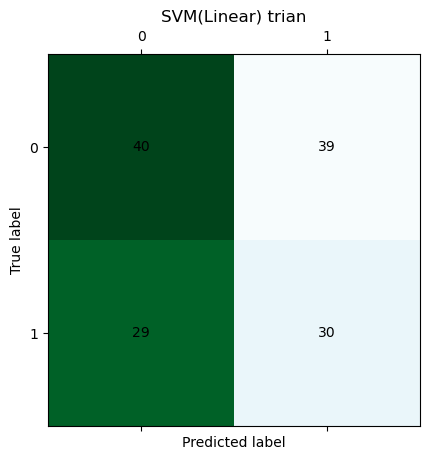

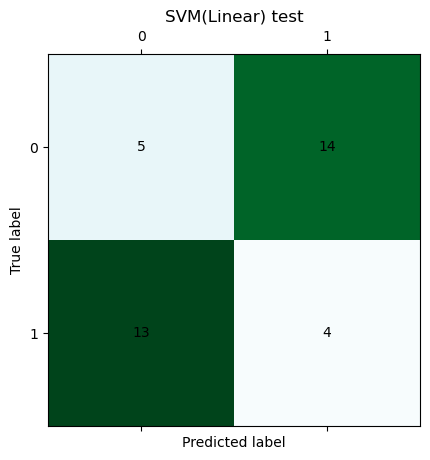

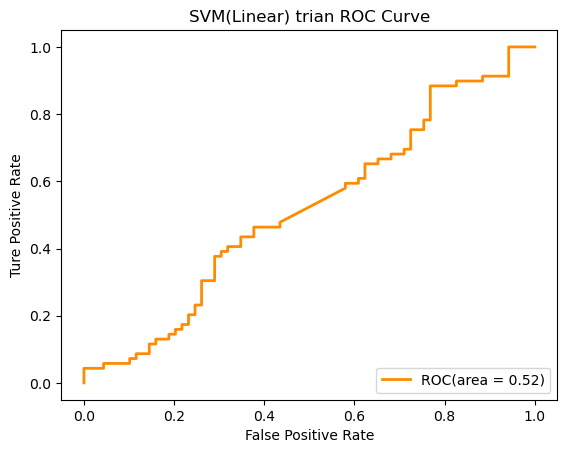

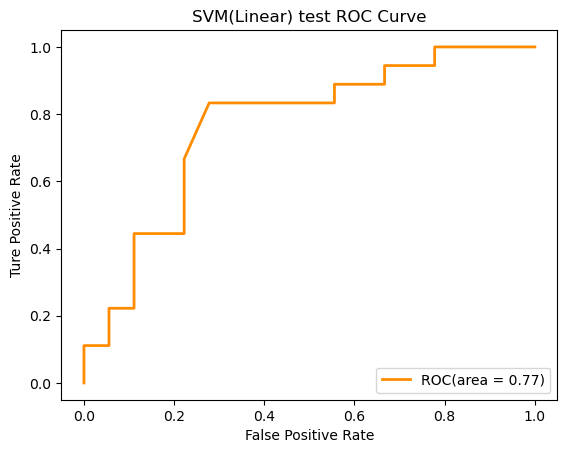

In [23]:
train_title ='SVM(Linear) trian'
test_title ='SVM(Linear) test'
ConfusionMatrix(train_y,lineartrain_predicted,train_title)
ConfusionMatrix(test_y,lineartest_predicted,test_title)
train_auc3,fpr_train3, tpr_train3 = plot_ROC_Curve(train_y,lineartrain_predicted_pro[:,1],train_title)
test_auc3,fpr_test3, tpr_test3 = plot_ROC_Curve(test_y,lineartest_predicted_pro[:,1],test_title)

In [24]:
name = 'SVM Linear'

train_df = train_result(lineartrain_predicted ,name,train_auc3)
test_df = test_result(lineartest_predicted ,name,test_auc3)

C:\Users\Huici\AppData\Local\Temp\1\ipykernel_33160\4260509582.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_df = pd.concat([train_df, df], axis=0, ignore_index=True)
C:\Users\Huici\AppData\Local\Temp\1\ipykernel_33160\1588876271.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  test_df = pd.concat([test_df, df], axis=0, ignore_index=True)


In [25]:
crossvalidation(linearSvcModel,name)

C:\Users\Huici\.conda\envs\py310_env\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Huici\.conda\envs\py310_env\lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Huici\.conda\envs\py310_env\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Huici\.conda\envs\py310_env\lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.

Model name  dataset  accuracy_mean  accuracy_std  precision_mean  \
0  SVM Linear  10-fold       0.493464      0.113007        0.483601   

   precision_std  recall_mean  recall_std  f1-score_mean  f1-score_std  \
0       0.120401     0.556944    0.285874       0.493127      0.179614   

   auc_mean   auc_std  
0  0.525154  0.119029

In [26]:
# 建立 svm kernel = poly 模型
polySvcModel=svm.SVC(C=0.5, max_iter=3000,kernel='poly',probability=True)
# 使用訓練資料訓練模型
polySvcModel.fit(train_X, train_y)
# 使用訓練資料預測分類
polytrain_predicted=polySvcModel.predict(train_X)
polytest_predicted=polySvcModel.predict(test_X)

polytrain_predicted_pro=polySvcModel.predict_proba(train_X)
polytest_predicted_pro=polySvcModel.predict_proba(test_X)


C:\Users\Huici\.conda\envs\py310_env\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


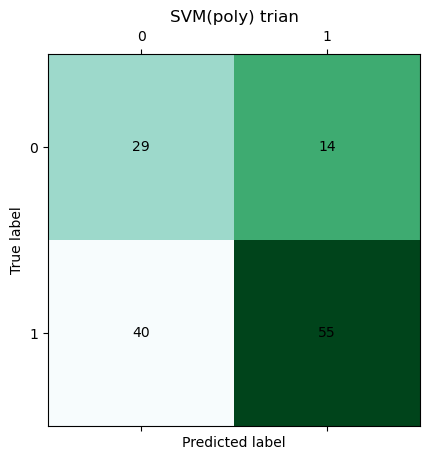

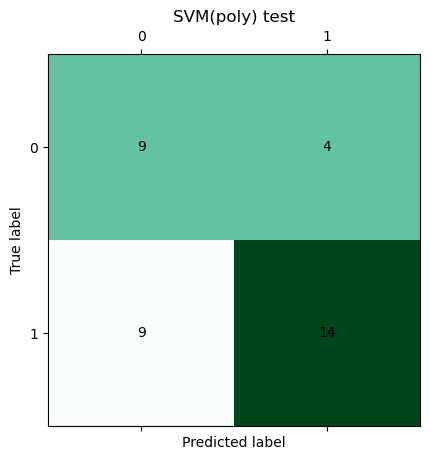

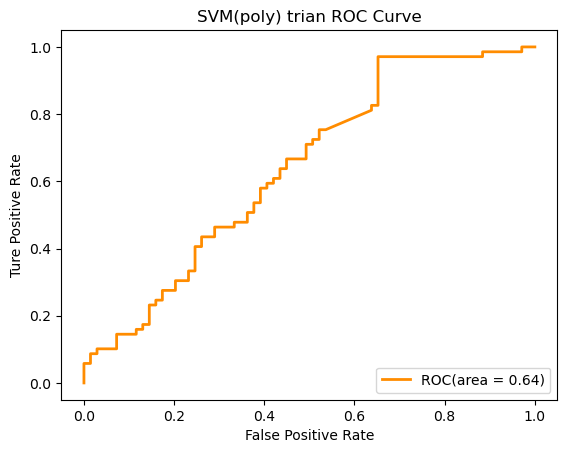

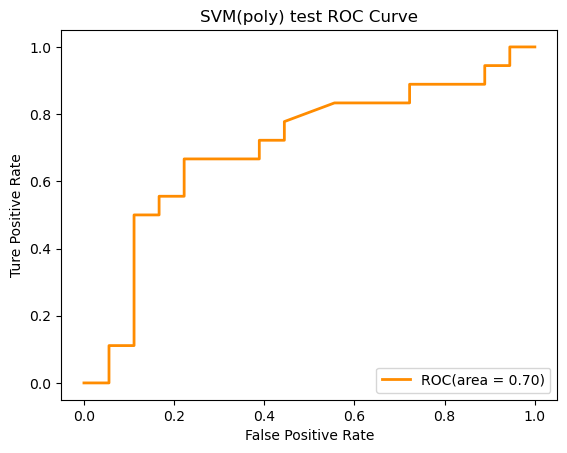

In [27]:
train_title ='SVM(poly) trian'
test_title ='SVM(poly) test'
ConfusionMatrix(train_y,polytrain_predicted,train_title)
ConfusionMatrix(test_y,polytest_predicted,test_title)
train_auc4,fpr_train4, tpr_train4 = plot_ROC_Curve(train_y,polytrain_predicted_pro[:,1],train_title)
test_auc4,fpr_test4, tpr_test4 =plot_ROC_Curve(test_y,polytest_predicted_pro[:,1],test_title)

In [28]:
name = 'SVM Poly'

train_df = train_result(polytrain_predicted ,name,train_auc4)
test_df = test_result(polytest_predicted ,name,test_auc4)

In [29]:
crossvalidation(polySvcModel,name)

C:\Users\Huici\.conda\envs\py310_env\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Huici\.conda\envs\py310_env\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Huici\.conda\envs\py310_env\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Huici\.conda\envs\py310_env\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expec

Model name  dataset  accuracy_mean  accuracy_std  precision_mean  \
0  SVM Linear  10-fold       0.493464      0.113007        0.483601   
1    SVM Poly  10-fold       0.603922      0.093578        0.571934   

   precision_std  recall_mean  recall_std  f1-score_mean  f1-score_std  \
0       0.120401     0.556944    0.285874       0.493127      0.179614   
1       0.064848     0.862500    0.125505       0.684497      0.074698   

   auc_mean   auc_std  
0  0.525154  0.119029  
1  0.614043  0.127838

Model name  dataset  accuracy_mean  accuracy_std  precision_mean  \
0        SVM RBF  10-fold       0.600000      0.129986        0.582597   
1  Decision Tree  10-fold       0.718182      0.079600        0.655357   
2  Random Forest  10-fold       0.781818      0.114992        0.777857   
3        XGBoost  10-fold       0.809091      0.067079        0.807619   
4       AdaBoost  10-fold       0.727273      0.128565        0.712857   
5  GradientBoost  10-fold       0.763636      0.087827        0.745317   
6     SVM Linear  10-fold       0.620282      0.143965        0.151703   
7       SVM Poly  10-fold       0.908051      0.008502        0.000000   

   precision_std  recall_mean  recall_std  f1-score_mean  f1-score_std  \
0       0.116759     0.820000    0.146734       0.671687      0.095658   
1       0.069271     0.950000    0.112491       0.770073      0.062149   
2       0.112799     0.806667    0.245352       0.772078      0.147681   
3       0.116171     0.856667    0.144914       0.816469      0.060699   
4       0.138502     0.783333    0.229465       0.728577      0.152745   
5       0.094757     0.860000    0.155397       0.784567      0.066341   
6       0.139444     0.440000    0.224873       0.189856      0.104132   
7       0.000000     0.000000    0.000000       0.000000      0.000000   

   auc_mean   auc_std  
0  0.726667  0.138600  
1  0.758333  0.089322  
2  0.893333  0.113093  
3  0.910000  0.066759  
4  0.810000  0.105468  
5  0.906667  0.079815  
6  0.551827  0.140172  
7  0.676712  0.140284

In [30]:
# 建立 svm kernel = rbf 模型
rbfSvcModel=svm.SVC(C=0.5, max_iter=3000,kernel='rbf',probability=True)
# 使用訓練資料訓練模型
rbfSvcModel.fit(train_X, train_y)
# 使用訓練資料預測分類
rbftrain_predicted=rbfSvcModel.predict(train_X)
rbftest_predicted=rbfSvcModel.predict(test_X)

rbftrain_predicted_pro=rbfSvcModel.predict_proba(train_X)
rbftest_predicted_pro=rbfSvcModel.predict_proba(test_X)

# 計算準確率
print('rbf訓練集: ',rbfSvcModel.score(train_X,train_y))
print('rbf測試集: ',rbfSvcModel.score(test_X,test_y))
print('========================')

rbf訓練集:  0.5579710144927537
rbf測試集:  0.5833333333333334


C:\Users\Huici\.conda\envs\py310_env\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


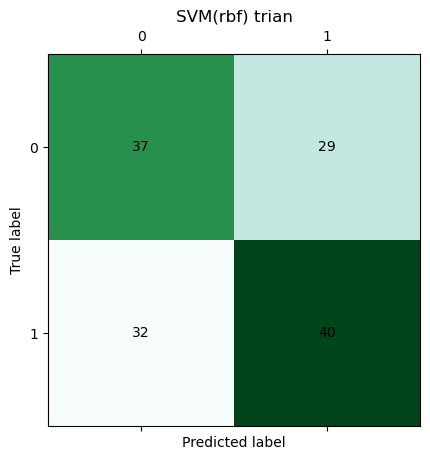

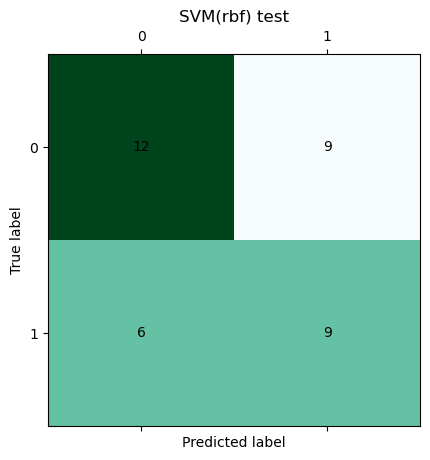

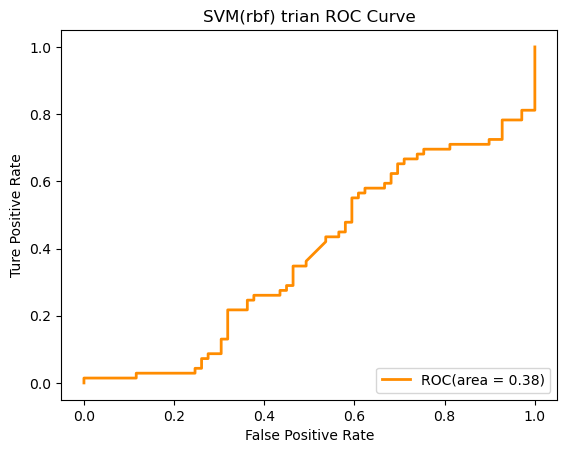

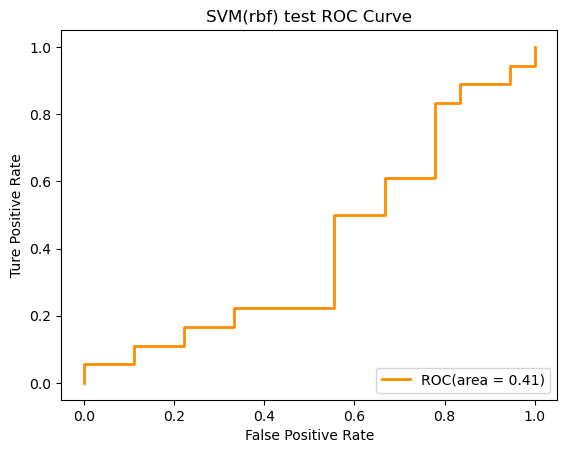

In [31]:
train_title ='SVM(rbf) trian'
test_title ='SVM(rbf) test'
ConfusionMatrix(train_y,rbftrain_predicted,train_title)
ConfusionMatrix(test_y,rbftest_predicted,test_title)
train_auc5,fpr_train5, tpr_train5 = plot_ROC_Curve(train_y,rbftrain_predicted_pro[:,1],train_title)
test_auc5,fpr_test5, tpr_test5 = plot_ROC_Curve(test_y,rbftest_predicted_pro[:,1],test_title)

In [32]:
name = 'SVM RBF'

train_df = train_result(rbftrain_predicted ,name,train_auc5)
test_df = test_result(rbftest_predicted ,name,test_auc5)

In [33]:
crossvalidation(rbfSvcModel,name)

C:\Users\Huici\.conda\envs\py310_env\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Huici\.conda\envs\py310_env\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Huici\.conda\envs\py310_env\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Huici\.conda\envs\py310_env\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expec

Model name  dataset  accuracy_mean  accuracy_std  precision_mean  \
0  SVM Linear  10-fold       0.493464      0.113007        0.483601   
1    SVM Poly  10-fold       0.603922      0.093578        0.571934   
2     SVM RBF  10-fold       0.568954      0.105056        0.551974   

   precision_std  recall_mean  recall_std  f1-score_mean  f1-score_std  \
0       0.120401     0.556944    0.285874       0.493127      0.179614   
1       0.064848     0.862500    0.125505       0.684497      0.074698   
2       0.077929     0.758333    0.160935       0.634079      0.094698   

   auc_mean   auc_std  
0  0.525154  0.119029  
1  0.614043  0.127838  
2  0.604012  0.137347

Model name  dataset  accuracy_mean  accuracy_std  precision_mean  \
0  Decision Tree  10-fold       0.718182      0.079600        0.655357   
1  Random Forest  10-fold       0.781818      0.114992        0.777857   
2        XGBoost  10-fold       0.809091      0.067079        0.807619   
3       AdaBoost  10-fold       0.727273      0.128565        0.712857   
4  GradientBoost  10-fold       0.763636      0.087827        0.745317   
5     SVM Linear  10-fold       0.620282      0.143965        0.151703   
6       SVM Poly  10-fold       0.908051      0.008502        0.000000   
7        SVM RBF  10-fold       0.908051      0.008502        0.000000   

   precision_std  recall_mean  recall_std  f1-score_mean  f1-score_std  \
0       0.069271     0.950000    0.112491       0.770073      0.062149   
1       0.112799     0.806667    0.245352       0.772078      0.147681   
2       0.116171     0.856667    0.144914       0.816469      0.060699   
3       0.138502     0.783333    0.229465       0.728577      0.152745   
4       0.094757     0.860000    0.155397       0.784567      0.066341   
5       0.139444     0.440000    0.224873       0.189856      0.104132   
6       0.000000     0.000000    0.000000       0.000000      0.000000   
7       0.000000     0.000000    0.000000       0.000000      0.000000   

   auc_mean   auc_std  
0  0.758333  0.089322  
1  0.893333  0.113093  
2  0.910000  0.066759  
3  0.810000  0.105468  
4  0.906667  0.079815  
5  0.551827  0.140172  
6  0.676712  0.140284  
7  0.824048  0.113997

### Decision tree

criterion: 亂度的評估標準，gini/entropy。預設為gini。

max_depth: 樹的最大深度。

splitter: 特徵劃分點選擇標準，best/random。預設為best。

random_state: 亂數種子，確保每次訓練結果都一樣，splitter=random 才有用。

min_samples_split: 至少有多少資料才能再分

min_samples_leaf: 分完至少有多少資料才能分

In [35]:
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': [3, 5, 7, 10, None]}
grid_search = GridSearchCV(DecisionTreeClassifier(criterion='entropy', random_state=42), param_grid, cv=5)
grid_search.fit(train_X, train_y)

print("最佳 max_depth:", grid_search.best_params_['max_depth'])
decisionTreeModel = grid_search.best_estimator_
# 使用訓練資料訓練模型
decisionTreeModel.fit(train_X, train_y)
# 使用訓練資料預測分類
decisiontrain_predicted = decisionTreeModel.predict(train_X)
decisiontest_predicted = decisionTreeModel.predict(test_X)

decisiontrain_predicted_pro = decisionTreeModel.predict_proba(train_X)
decisiontest_predicted_pro = decisionTreeModel.predict_proba(test_X)

# 計算準確率
print('訓練集: ',decisionTreeModel.score(train_X,train_y))
print('測試集: ',decisionTreeModel.score(test_X,test_y))

最佳 max_depth: 10
訓練集:  1.0
測試集:  0.75


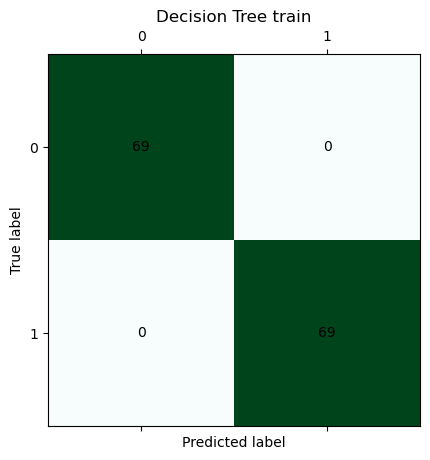

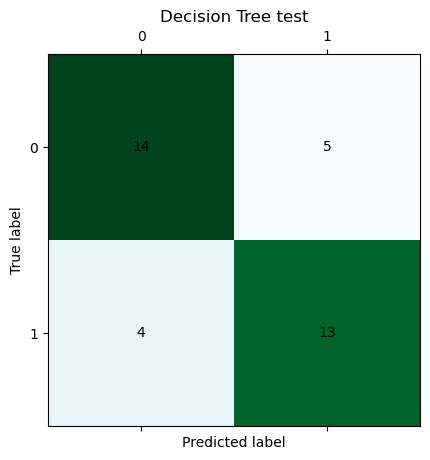

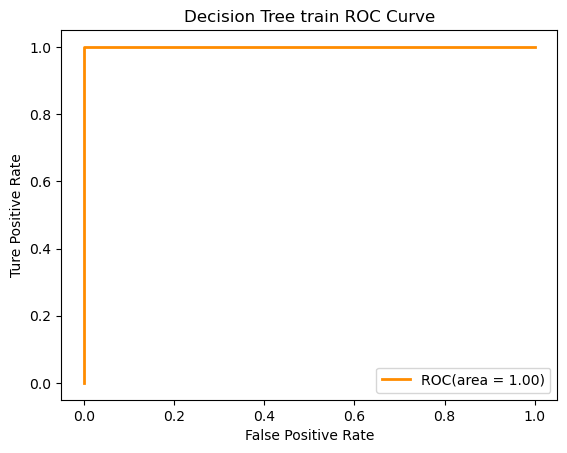

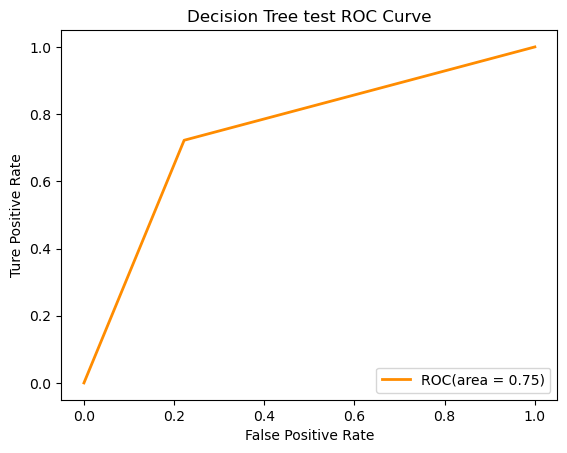

In [36]:
train_title ='Decision Tree train'
test_title ='Decision Tree test'
ConfusionMatrix(train_y,decisiontrain_predicted,train_title)
ConfusionMatrix(test_y,decisiontest_predicted,test_title)
train_auc7,fpr_train7, tpr_train7 = plot_ROC_Curve(train_y,decisiontrain_predicted_pro[:,1],train_title)
test_auc7,fpr_test7, tpr_test7 = plot_ROC_Curve(test_y,decisiontest_predicted_pro[:,1],test_title)

In [37]:
name = 'Decision Tree'

train_df = train_result(decisiontrain_predicted ,name,train_auc7)
test_df = test_result(decisiontest_predicted ,name,test_auc7)

In [38]:
crossvalidation(decisionTreeModel,name)

Model name  dataset  accuracy_mean  accuracy_std  precision_mean  \
0     SVM Linear  10-fold       0.493464      0.113007        0.483601   
1       SVM Poly  10-fold       0.603922      0.093578        0.571934   
2        SVM RBF  10-fold       0.568954      0.105056        0.551974   
3  Decision Tree  10-fold       0.718954      0.079049        0.741207   

   precision_std  recall_mean  recall_std  f1-score_mean  f1-score_std  \
0       0.120401     0.556944    0.285874       0.493127      0.179614   
1       0.064848     0.862500    0.125505       0.684497      0.074698   
2       0.077929     0.758333    0.160935       0.634079      0.094698   
3       0.125005     0.719444    0.188034       0.711183      0.103066   

   auc_mean   auc_std  
0  0.525154  0.119029  
1  0.614043  0.127838  
2  0.604012  0.137347  
3  0.727778  0.082675

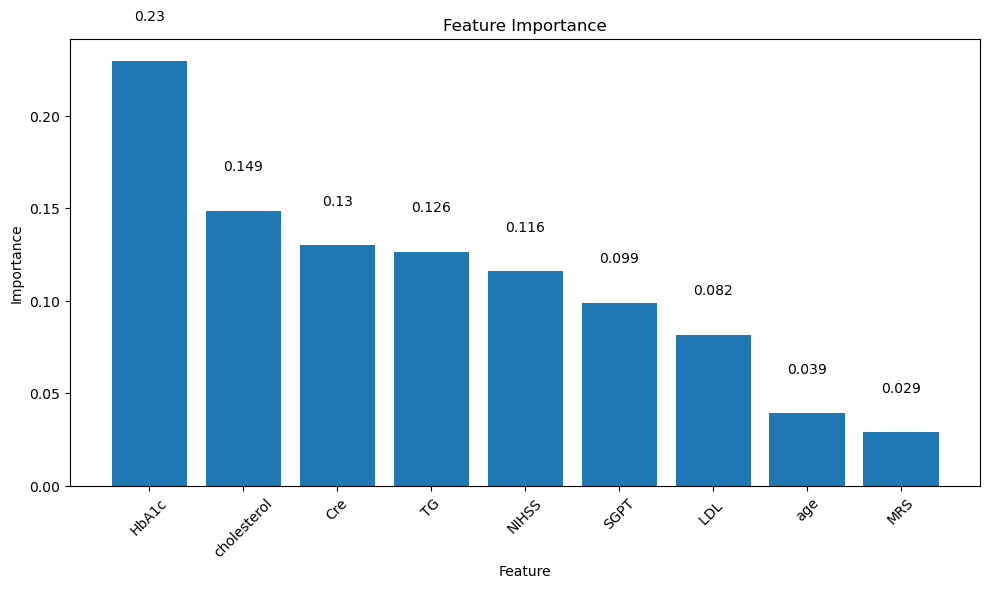

In [39]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

# 使用训练好的 Decision Tree 模型
decisionTreeModel = DecisionTreeClassifier(random_state=0)
decisionTreeModel.fit(train_X, train_y)

# 获取特征重要性
importances = decisionTreeModel.feature_importances_

# 获取特征名称
feature_names = train_X.columns

# 将特征重要性进行排序
indices = np.argsort(importances)[::-1]

# 画出特征重要性图表
plt.figure(figsize=(10, 6))
bars = plt.bar(range(train_X.shape[1]), importances[indices], align="center")
plt.xticks(range(train_X.shape[1]), feature_names[indices], rotation=45)
plt.title("Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Importance")

# 在每个条形上标示特征重要值数字
for bar, importance in zip(bars, importances[indices]):
    yval = round(importance, 3)
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, yval, ha='center', va='bottom')

plt.tight_layout()
plt.show()


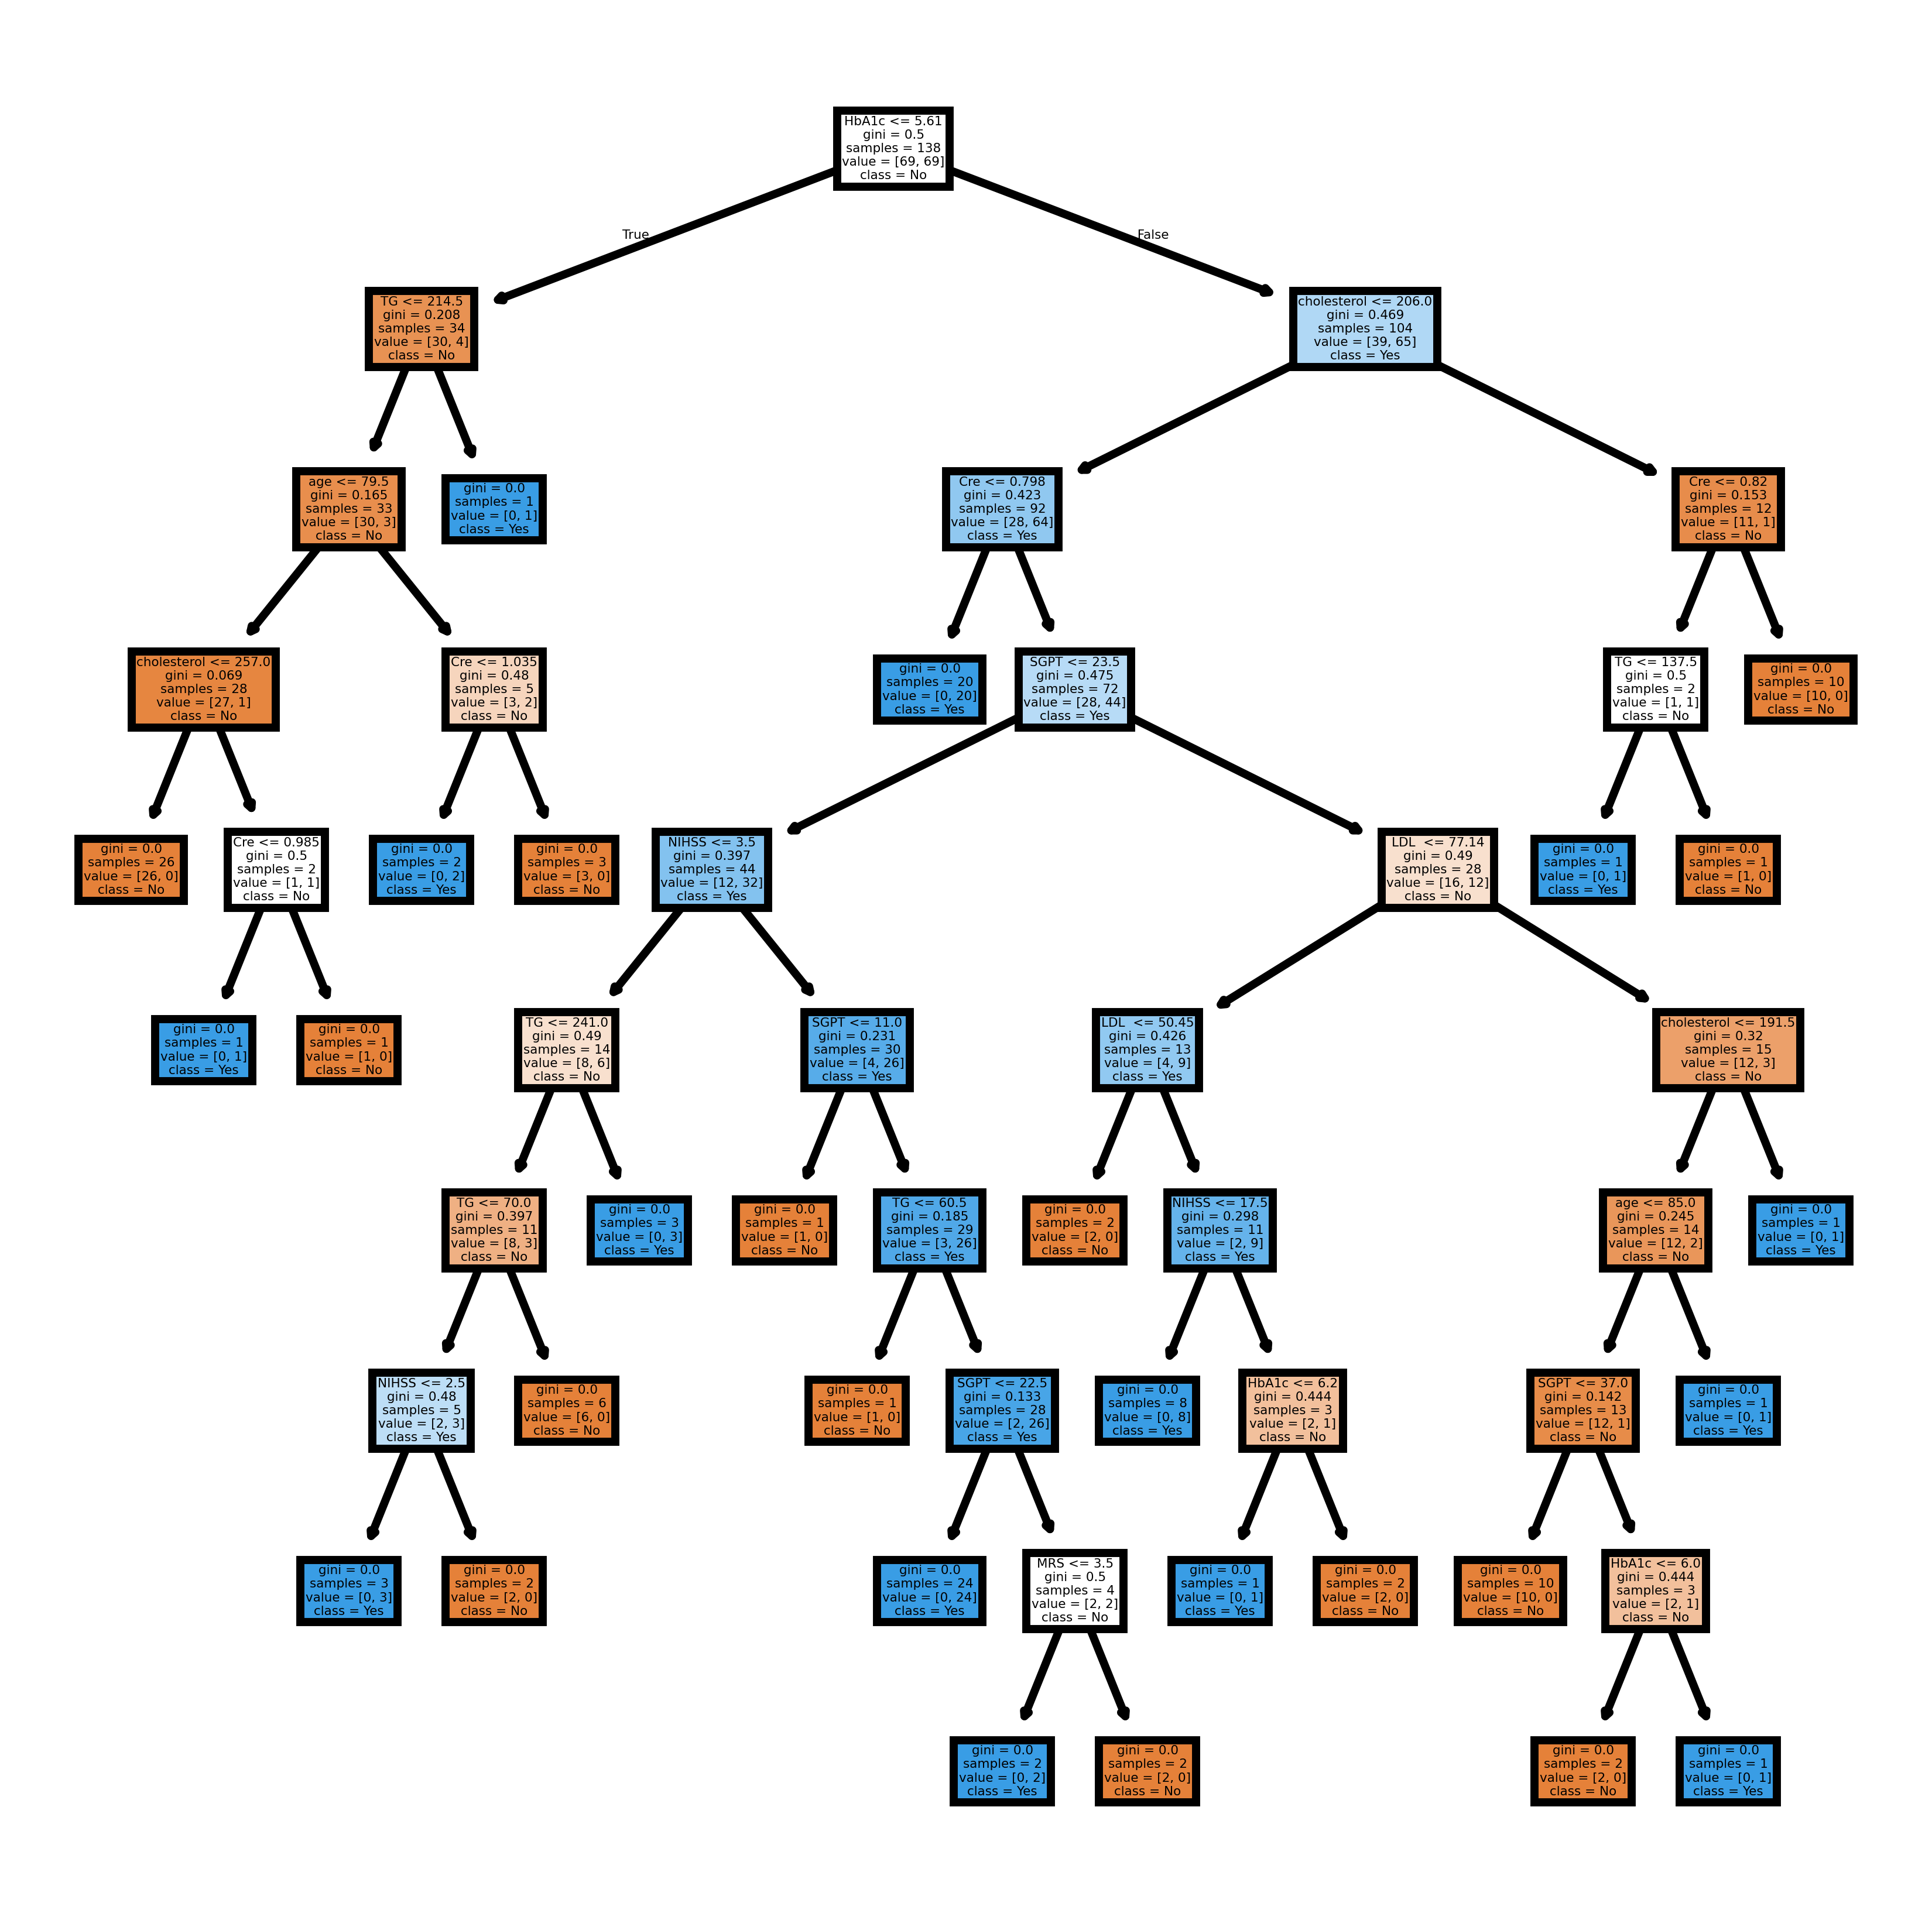

In [40]:
# 視覺化
from sklearn.tree import export_graphviz
decisionTreeModel.classes_ = ['0','1']
export_graphviz(decisionTreeModel, out_file=path+'decisiontree.dot',
                feature_names=['age', 'NIHSS',
       'LDL ', 'cholesterol', 'TG', 'Cre', 'SGPT', 'HbA1c', 'MRS'],
                class_names=decisionTreeModel.classes_)
fn=['age', 'NIHSS',
       'LDL ', 'cholesterol', 'TG', 'Cre', 'SGPT', 'HbA1c', 'MRS']
cn=[ 'No','Yes']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=1000)
tree.plot_tree(decisionTreeModel,
               feature_names = fn, 
               class_names=cn,
               filled = True);
fig.savefig(path+'Decision Tree.png')


## 集成式學習

### 隨機森林

n_estimators: 森林中樹木的數量，預設=100。

max_features: 劃分時考慮的最大特徵數，預設auto。

criterion: 亂度的評估標準，gini/entropy。預設為gini。

max_depth: 樹的最大深度。

splitter: 特徵劃分點選擇標準，best/random。預設為best。

random_state: 亂數種子，確保每次訓練結果都一樣，splitter=random 才有用。

min_samples_split: 至少有多少資料才能再分

min_samples_leaf: 分完至少有多少資料才能分


In [41]:
#建立隨機森林 model
forest = ensemble.RandomForestClassifier(criterion = 'entropy', n_estimators = 100, max_depth=5)
forest_fit = forest.fit(train_X, train_y)

# 預測
forest_train_predicted = forest.predict(train_X)
forest_test_predicted = forest.predict(test_X)

forest_train_predicted_pro = forest.predict_proba(train_X)
forest_test_predicted_pro = forest.predict_proba(test_X)

# 預測成功的比例
print('訓練集: ',forest.score(train_X,train_y))
print('測試集: ',forest.score(test_X,test_y))

C:\Users\Huici\.conda\envs\py310_env\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


訓練集:  0.9637681159420289
測試集:  0.8333333333333334


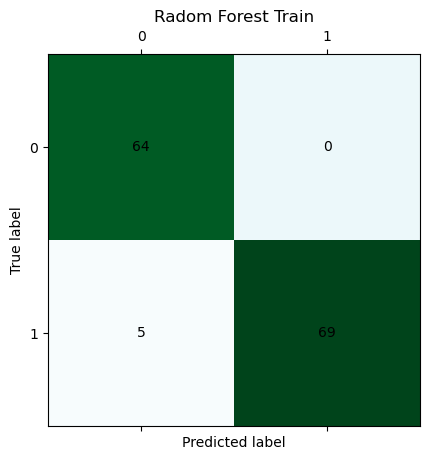

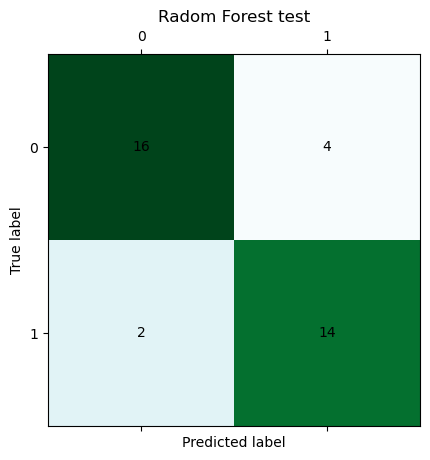

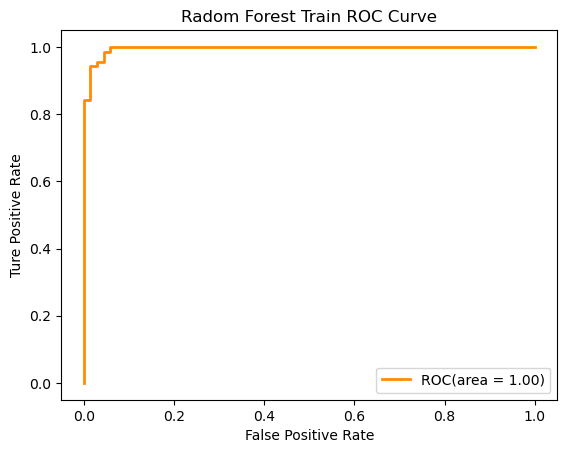

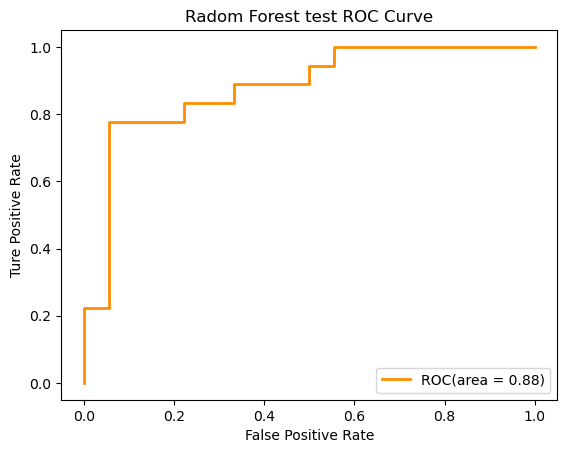

In [42]:
train_title ='Radom Forest Train'
test_title ='Radom Forest test'
ConfusionMatrix(train_y,forest_train_predicted,train_title)
ConfusionMatrix(test_y,forest_test_predicted,test_title)
train_auc8,fpr_train8, tpr_train8 = plot_ROC_Curve(train_y,forest_train_predicted_pro[:,1],train_title)
test_auc8,fpr_test8, tpr_test8 = plot_ROC_Curve(test_y,forest_test_predicted_pro[:,1],test_title)

In [43]:
name = 'Random Forest'

train_df = train_result(forest_train_predicted ,name,train_auc8)
test_df = test_result(forest_test_predicted ,name,test_auc8)

In [44]:
crossvalidation(forest,name)

C:\Users\Huici\.conda\envs\py310_env\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Huici\.conda\envs\py310_env\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Huici\.conda\envs\py310_env\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Huici\.conda\envs\py310_env\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. P

Model name  dataset  accuracy_mean  accuracy_std  precision_mean  \
0     SVM Linear  10-fold       0.493464      0.113007        0.483601   
1       SVM Poly  10-fold       0.603922      0.093578        0.571934   
2        SVM RBF  10-fold       0.568954      0.105056        0.551974   
3  Decision Tree  10-fold       0.718954      0.079049        0.741207   
4  Random Forest  10-fold       0.799020      0.053549        0.788611   

   precision_std  recall_mean  recall_std  f1-score_mean  f1-score_std  \
0       0.120401     0.556944    0.285874       0.493127      0.179614   
1       0.064848     0.862500    0.125505       0.684497      0.074698   
2       0.077929     0.758333    0.160935       0.634079      0.094698   
3       0.125005     0.719444    0.188034       0.711183      0.103066   
4       0.097398     0.843056    0.118946       0.806014      0.057160   

   auc_mean   auc_std  
0  0.525154  0.119029  
1  0.614043  0.127838  
2  0.604012  0.137347  
3  0.727778  0.082675  
4  0.899228  0.044281

C:\Users\Huici\.conda\envs\py310_env\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


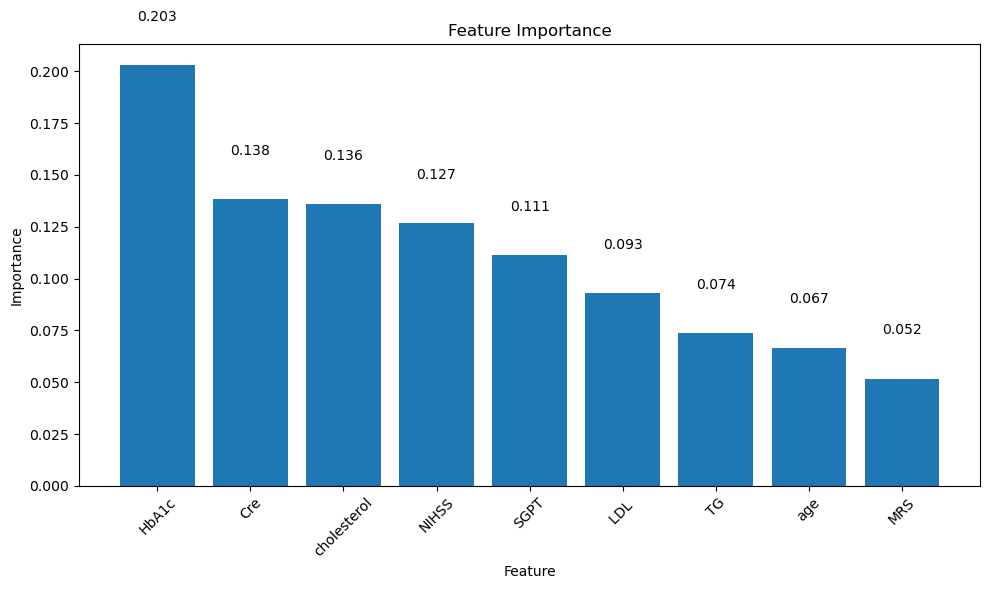

In [45]:
import matplotlib.pyplot as plt

# 使用訓練好的Random Forest模型
forest = RandomForestClassifier(n_estimators=100, random_state=0)
forest.fit(train_X, train_y)

# 獲取特徵重要性
importances = forest.feature_importances_

# 獲取特徵名稱
feature_names = train_X.columns

# 將特徵重要性進行排序
indices = np.argsort(importances)[::-1]

# 畫出特徵重要性圖表
plt.figure(figsize=(10, 6))
bars = plt.bar(range(train_X.shape[1]), importances[indices], align="center")
plt.xticks(range(train_X.shape[1]), feature_names[indices], rotation=45)
plt.title("Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Importance")

# 在每個條形上標示特徵重要值數字
for bar, importance in zip(bars, importances[indices]):
    yval = round(importance, 3)
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, yval, ha='center', va='bottom')

plt.tight_layout()
plt.show()


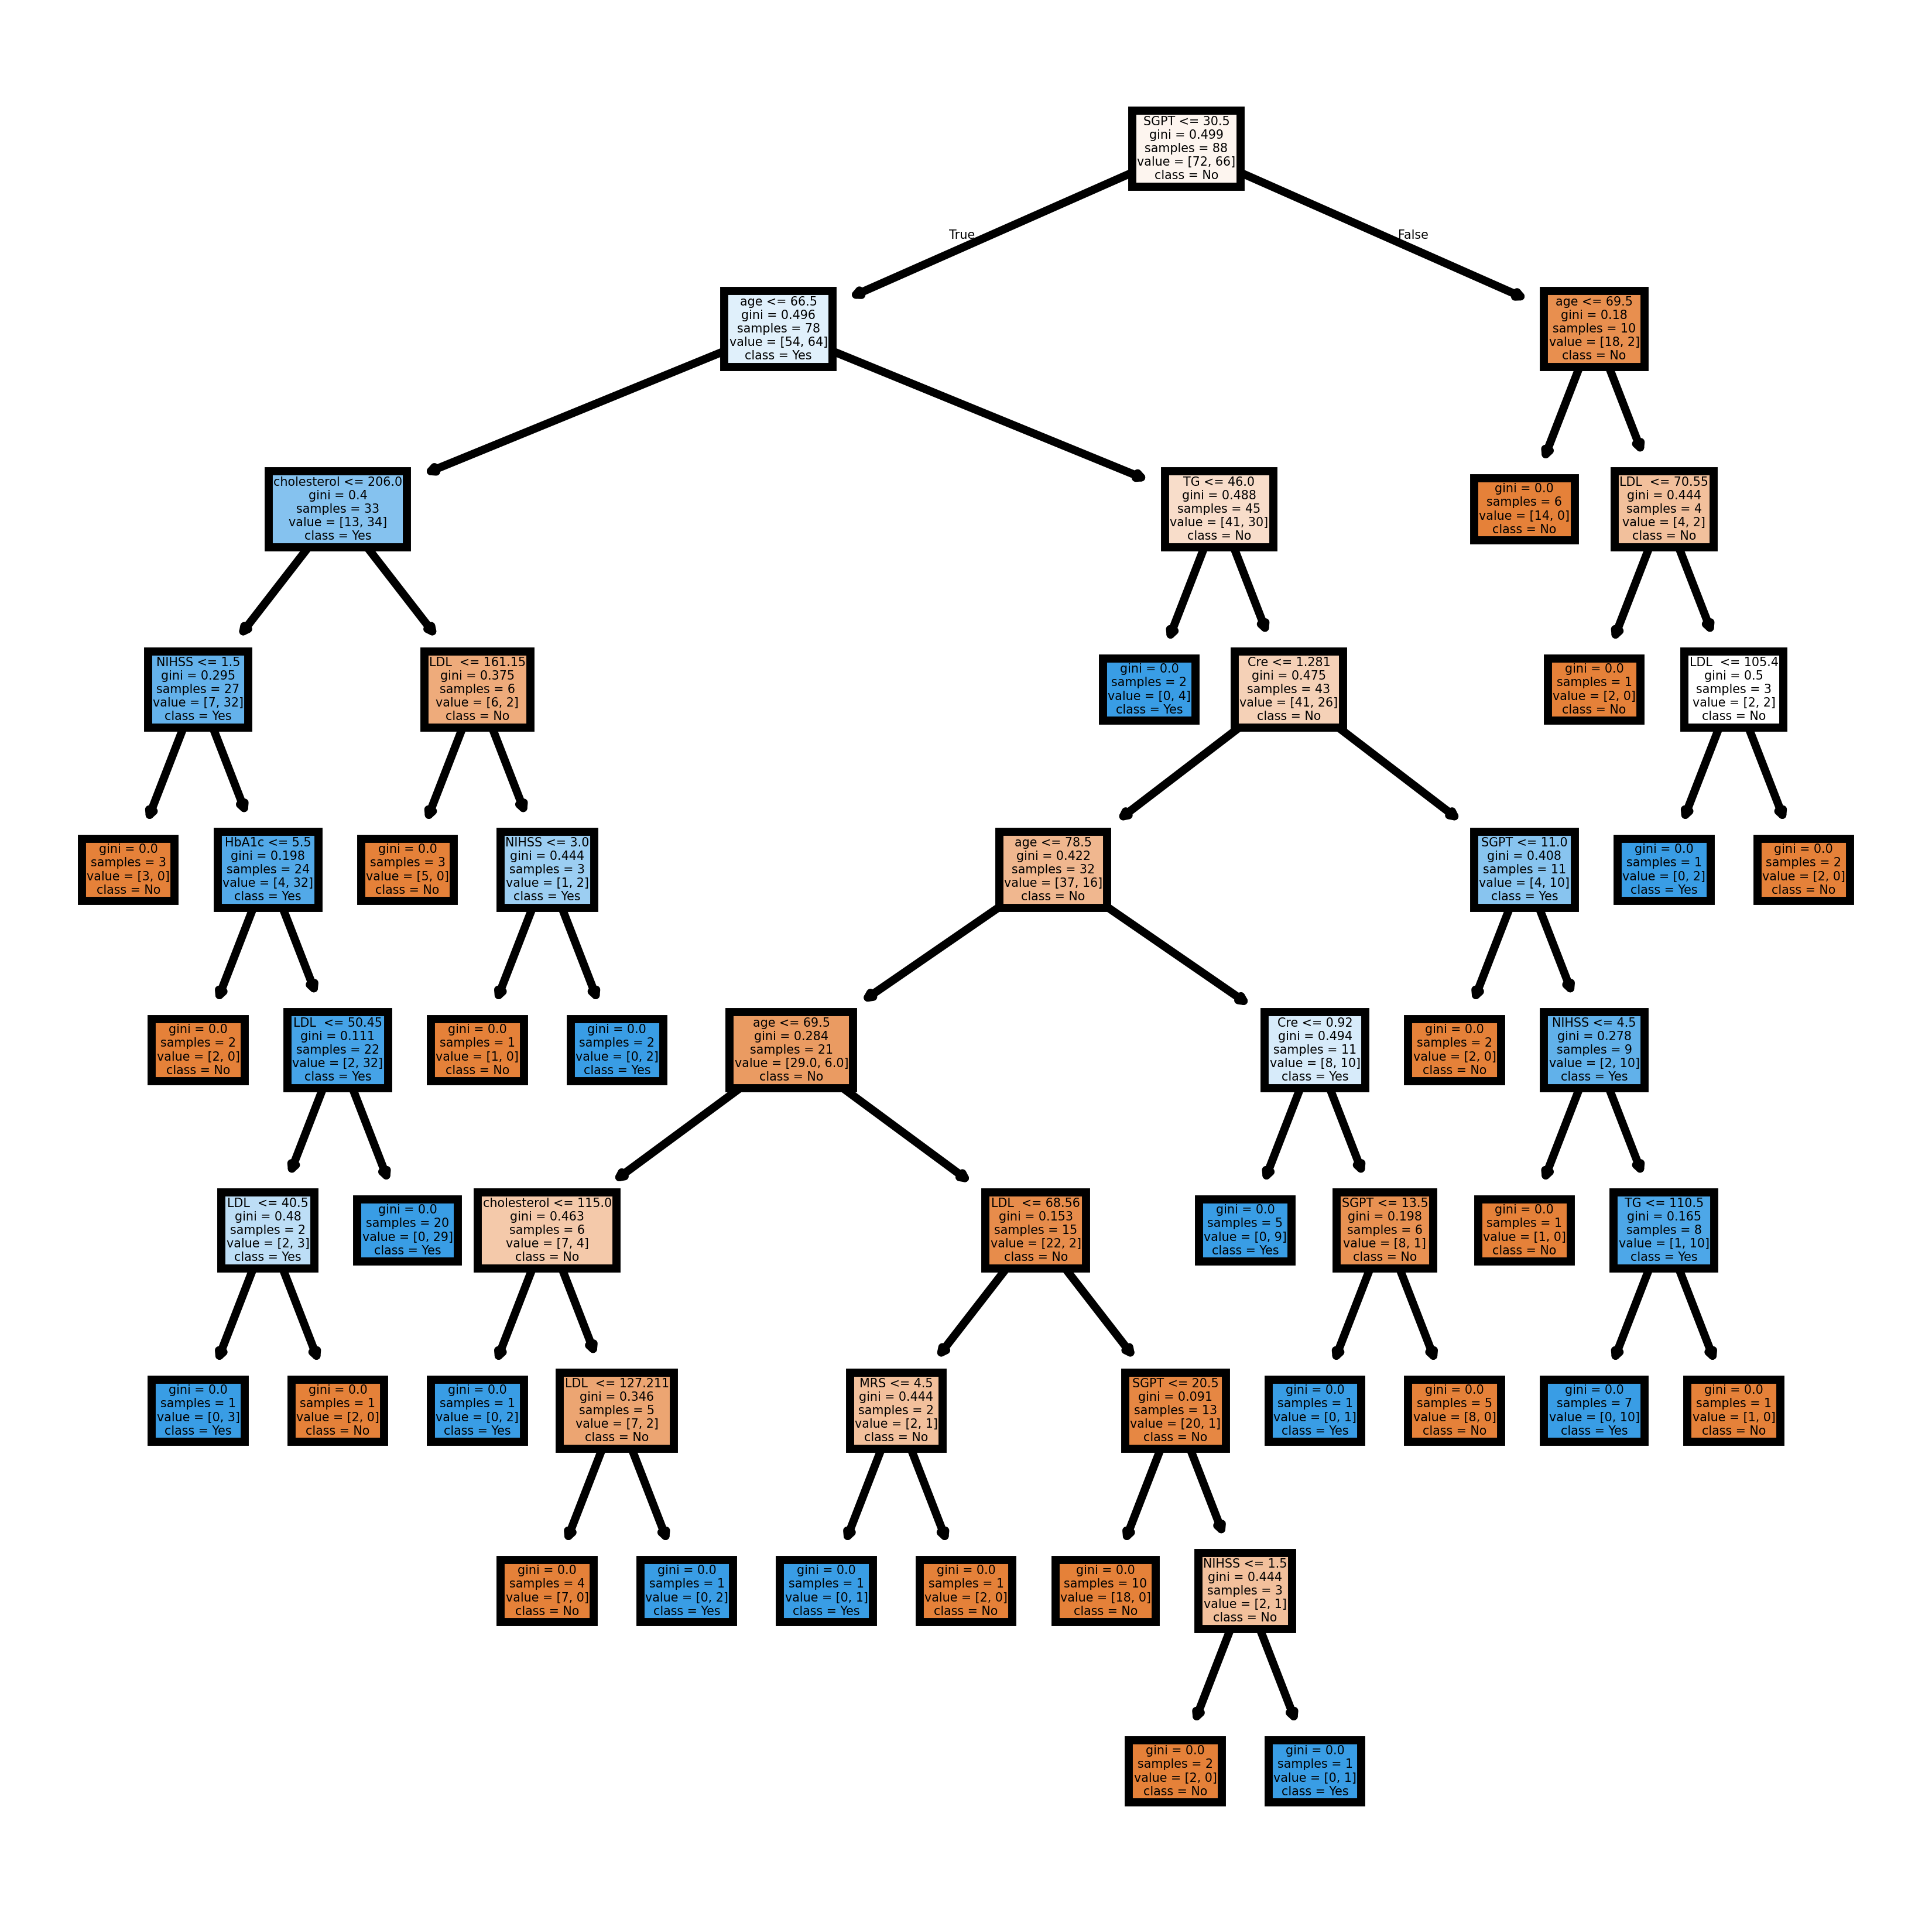

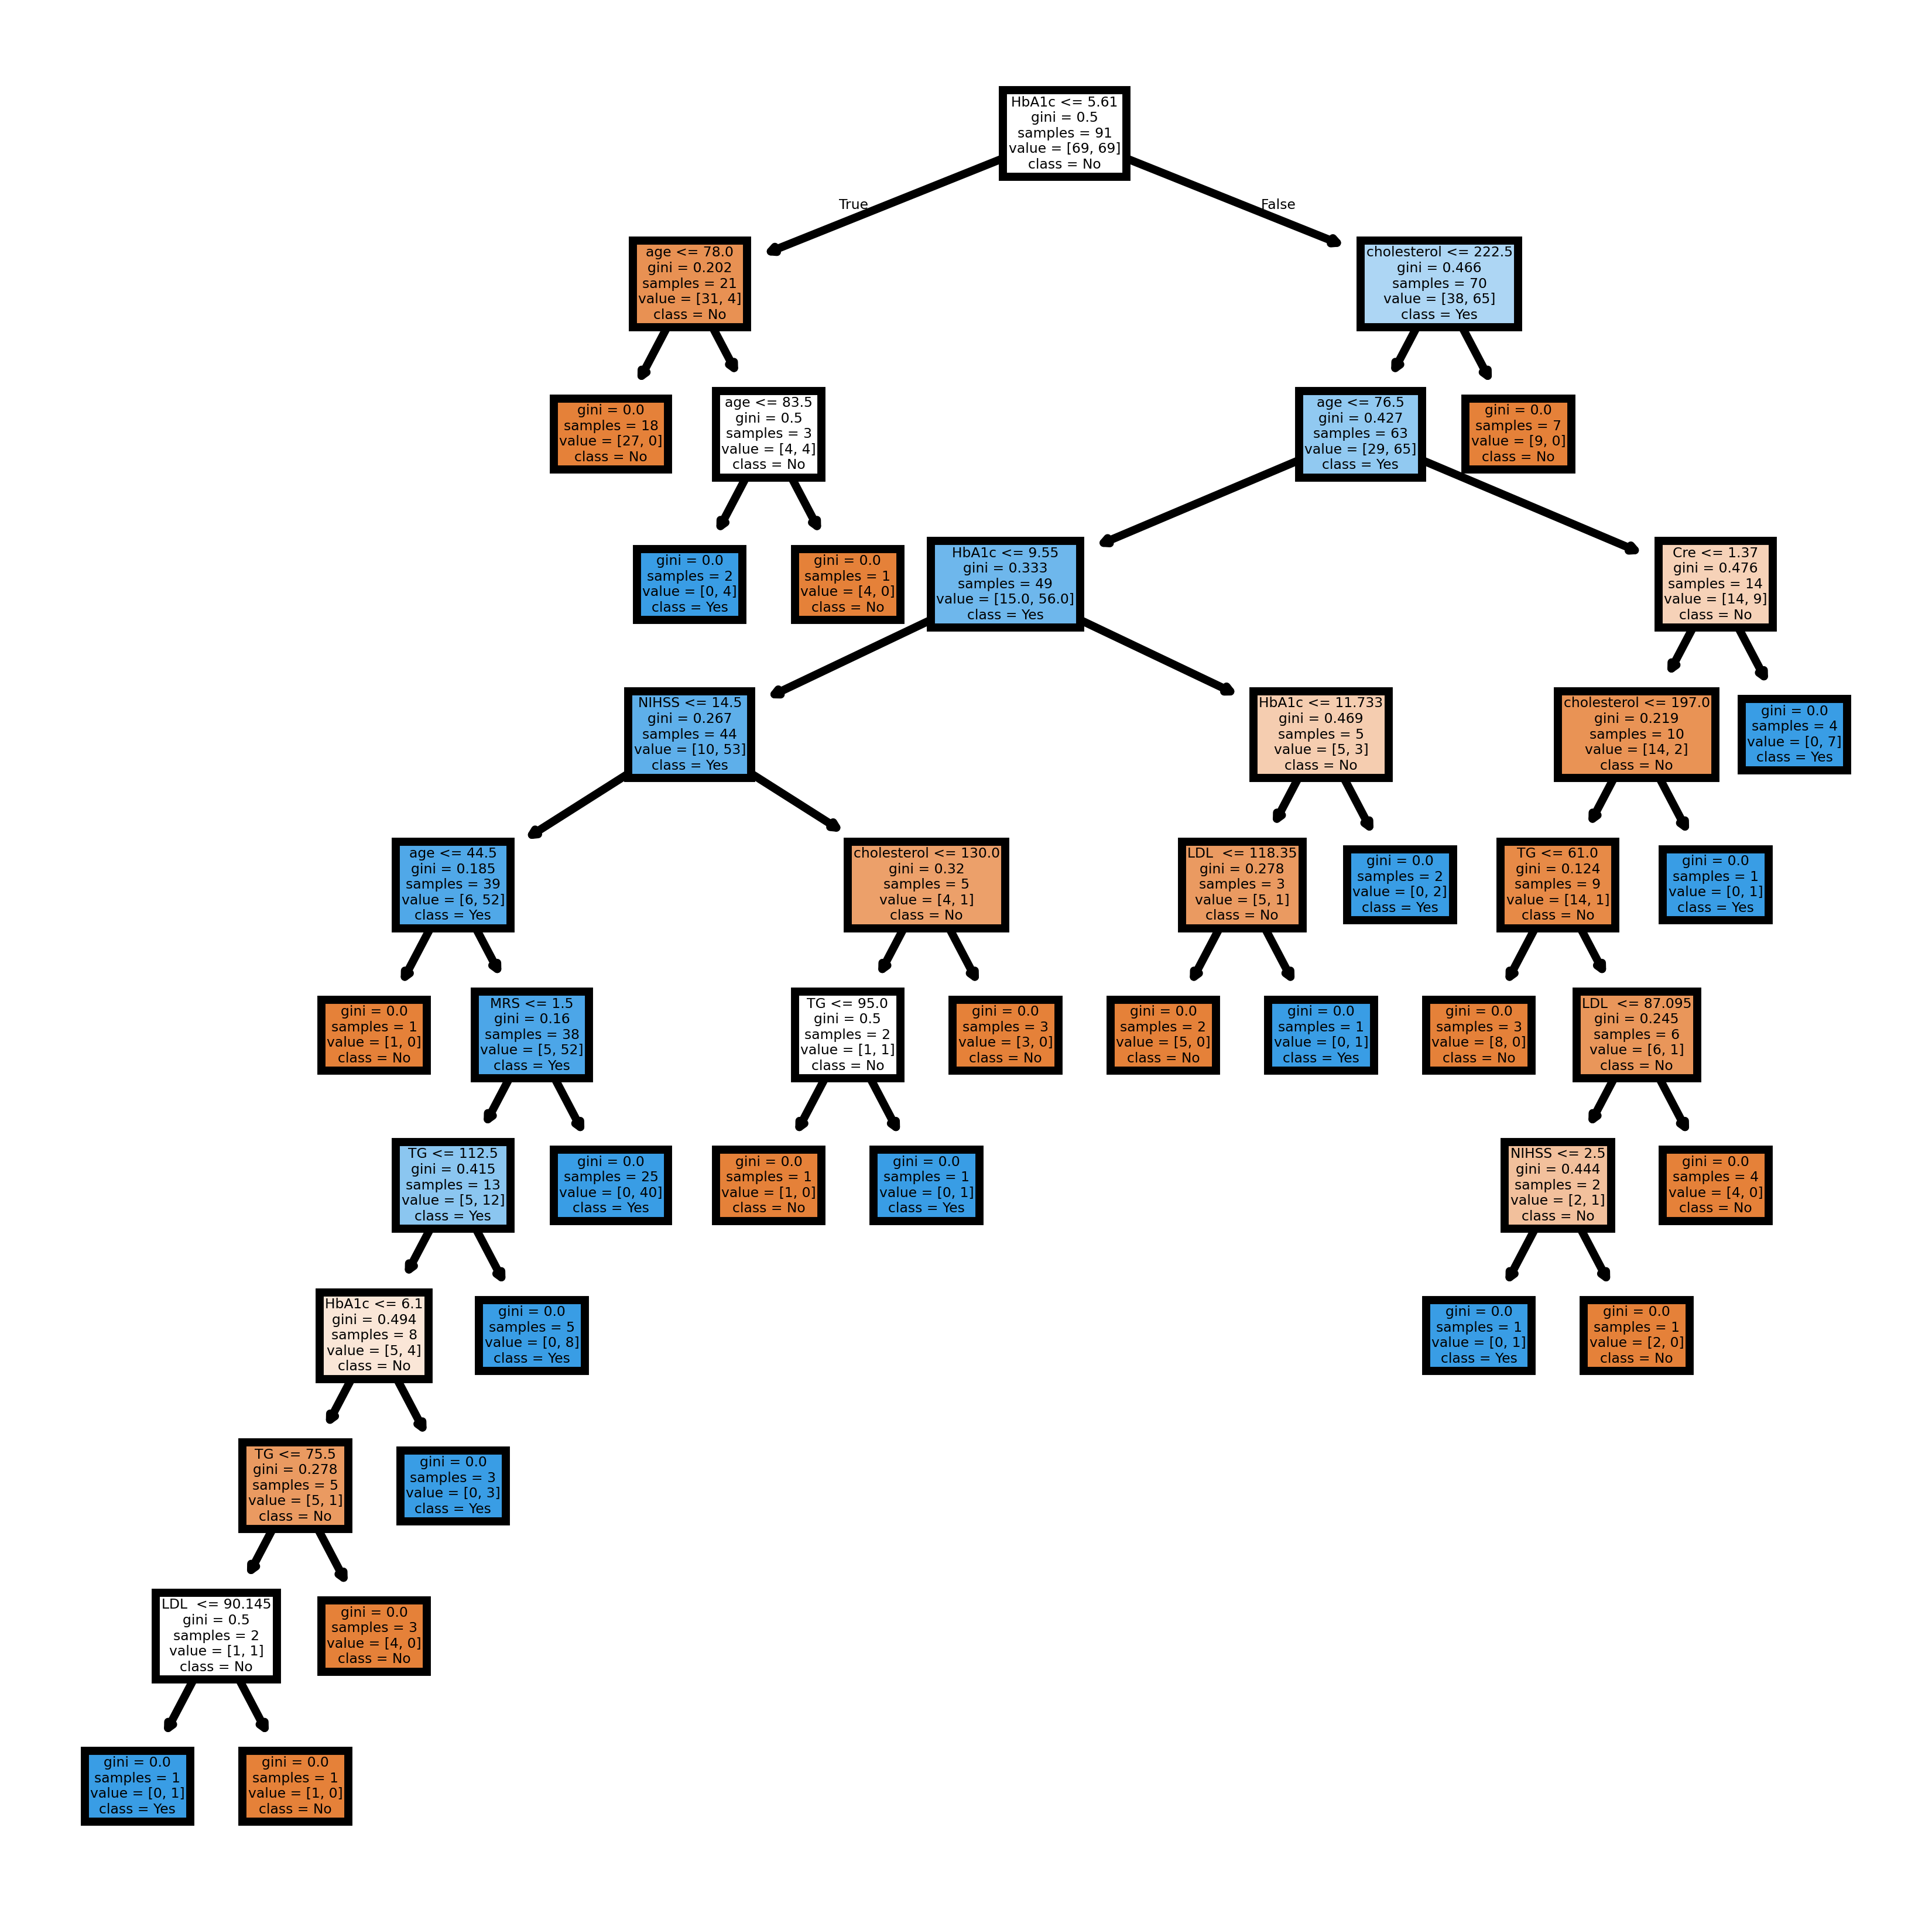

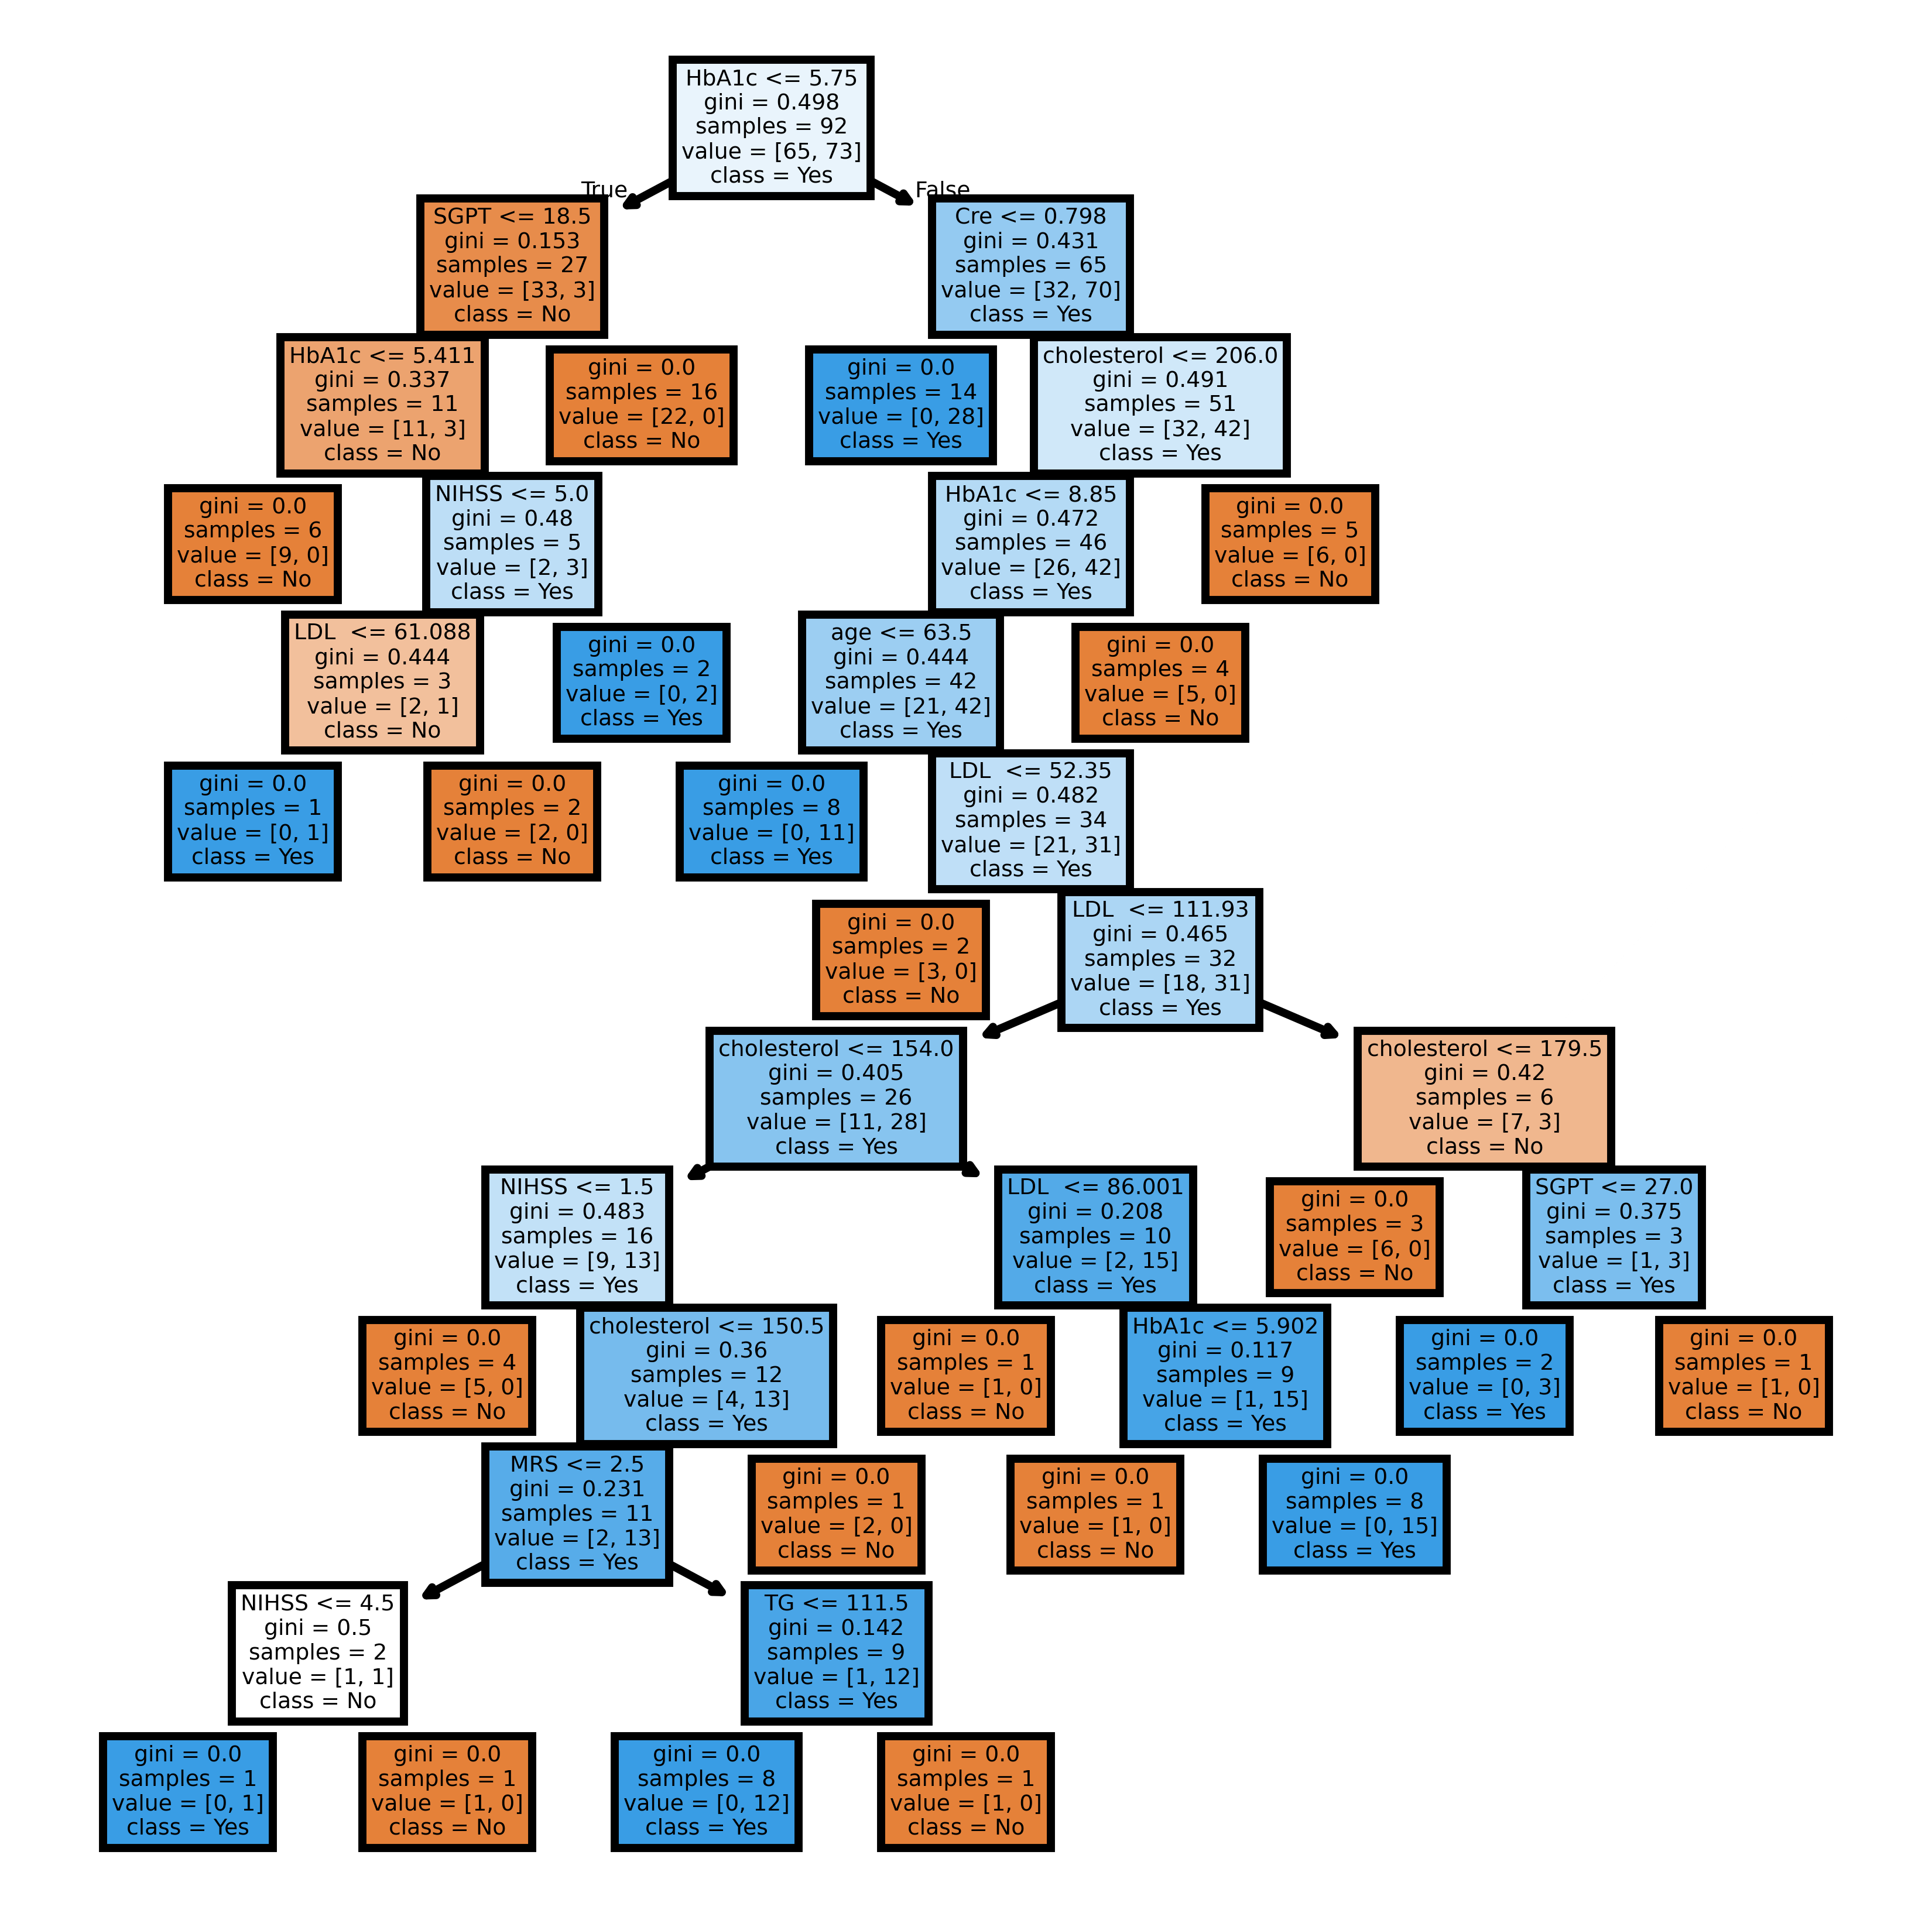

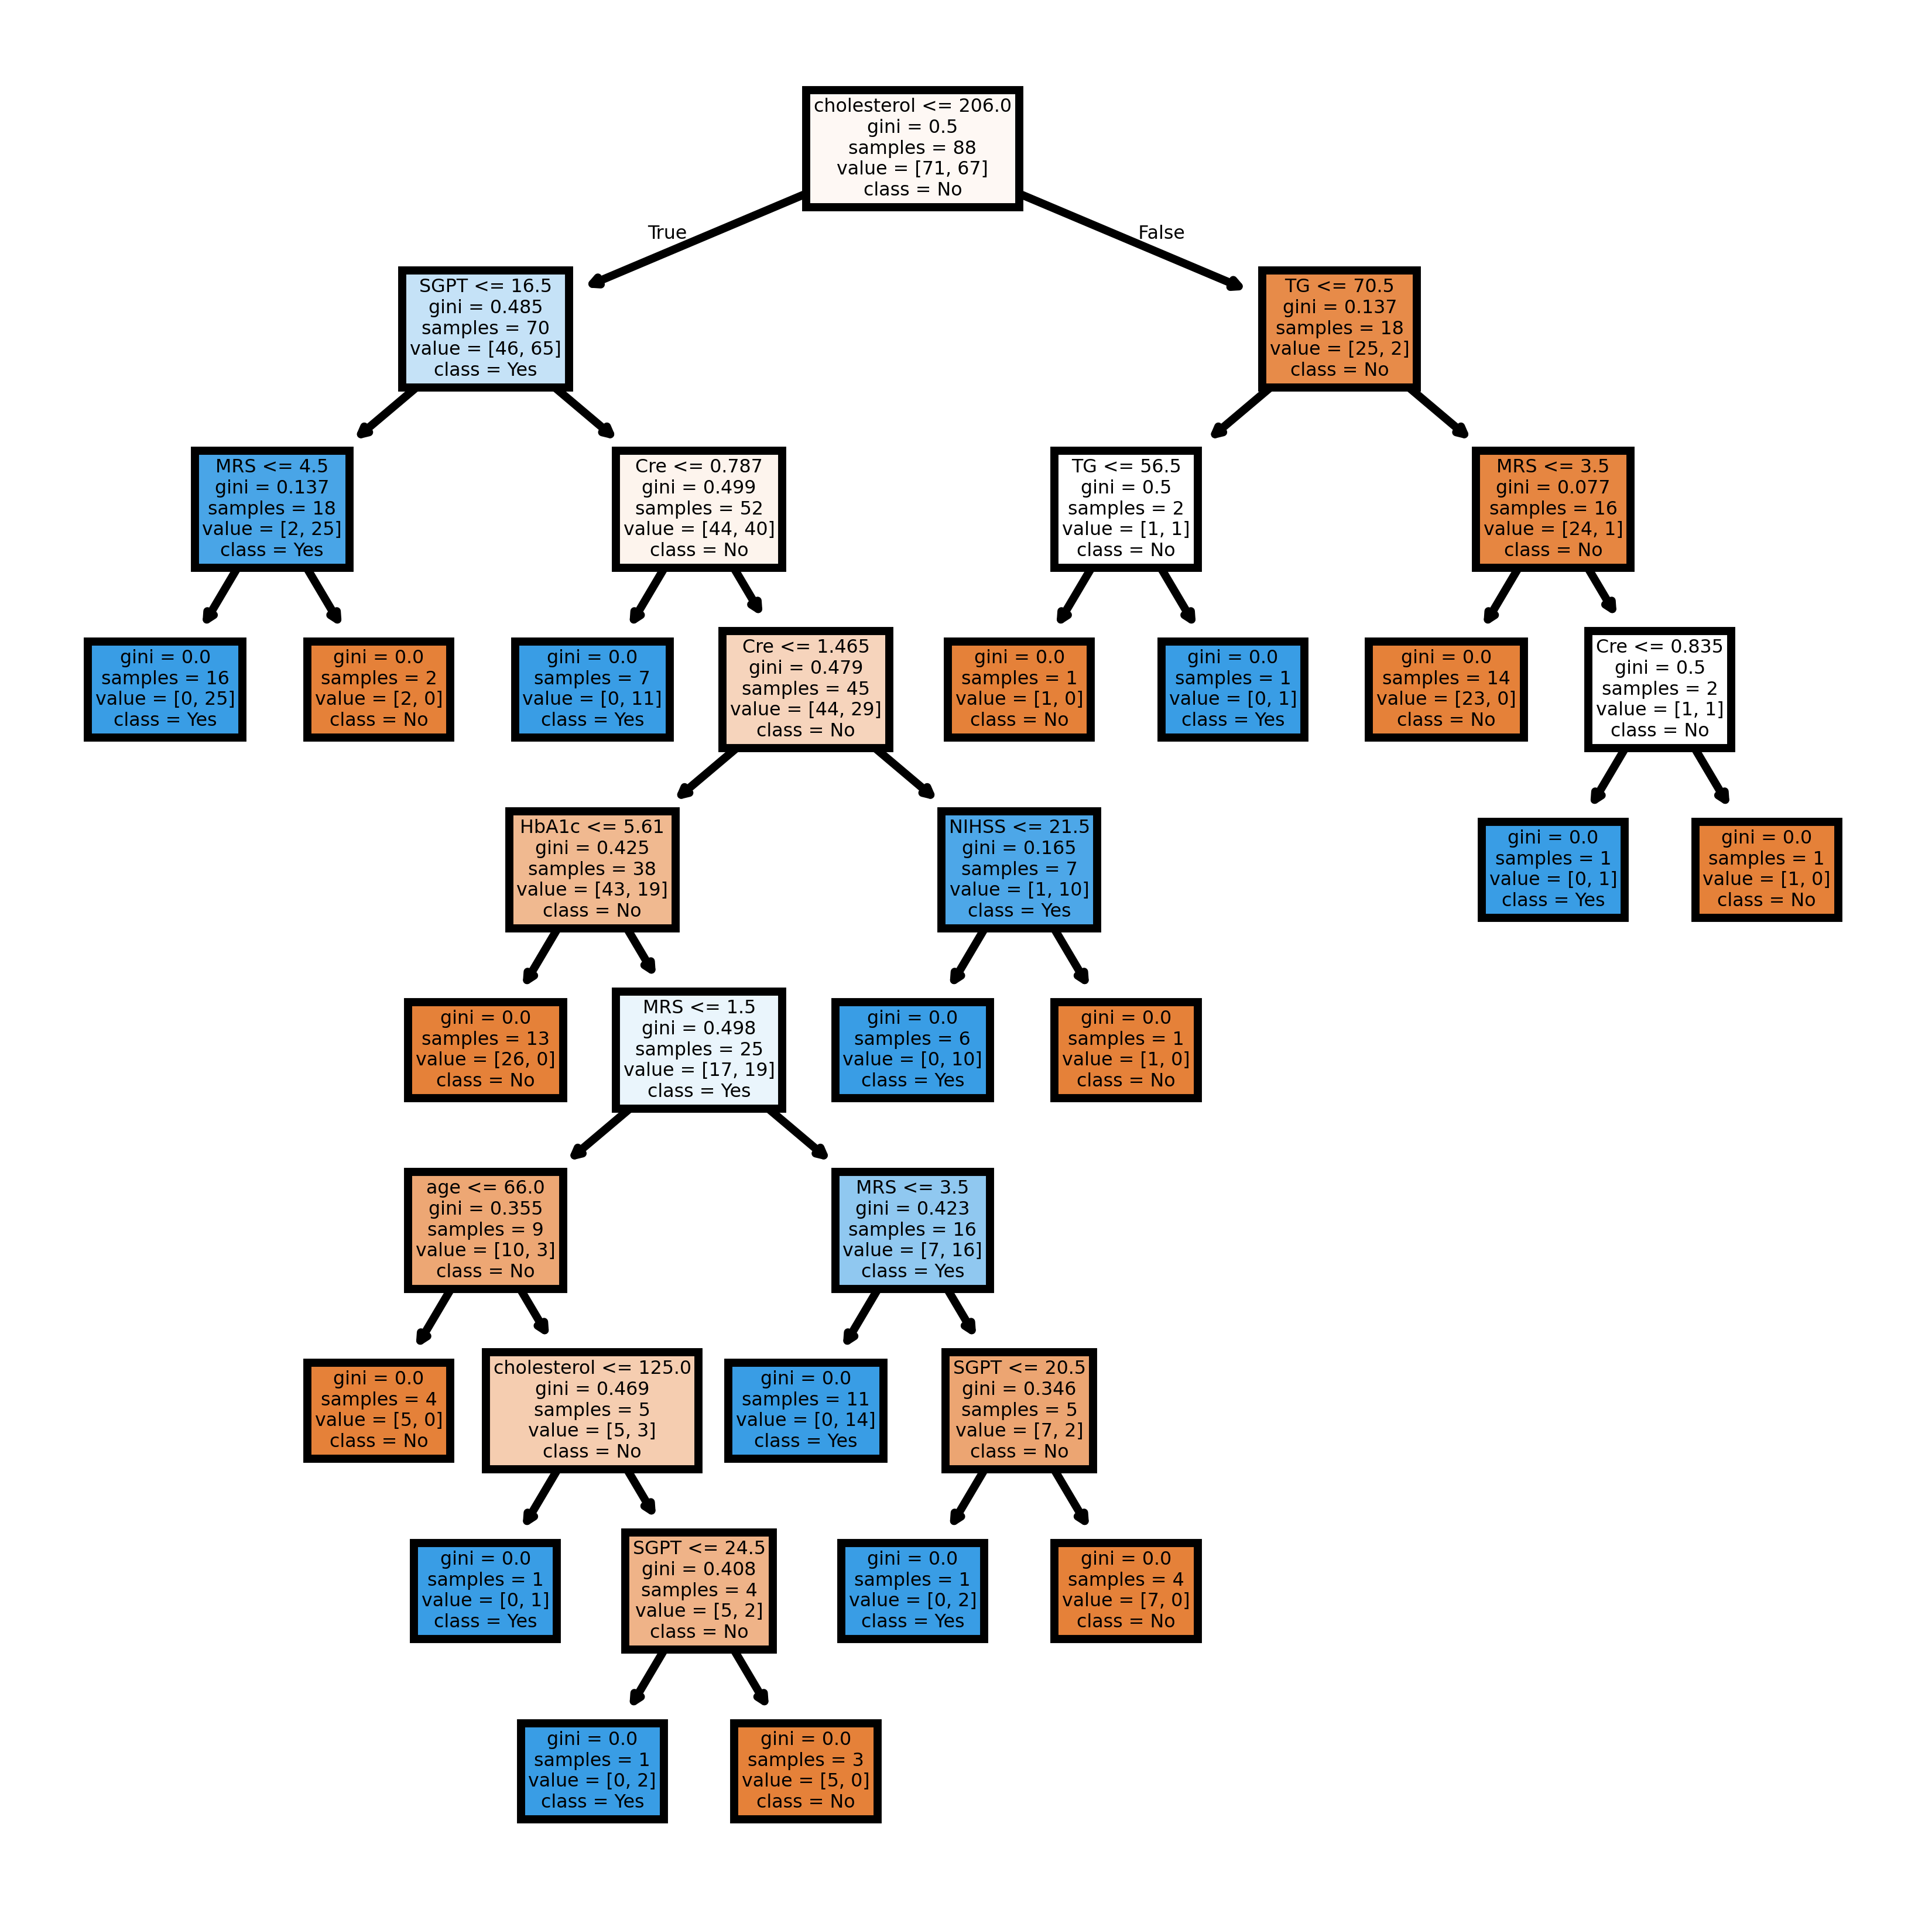

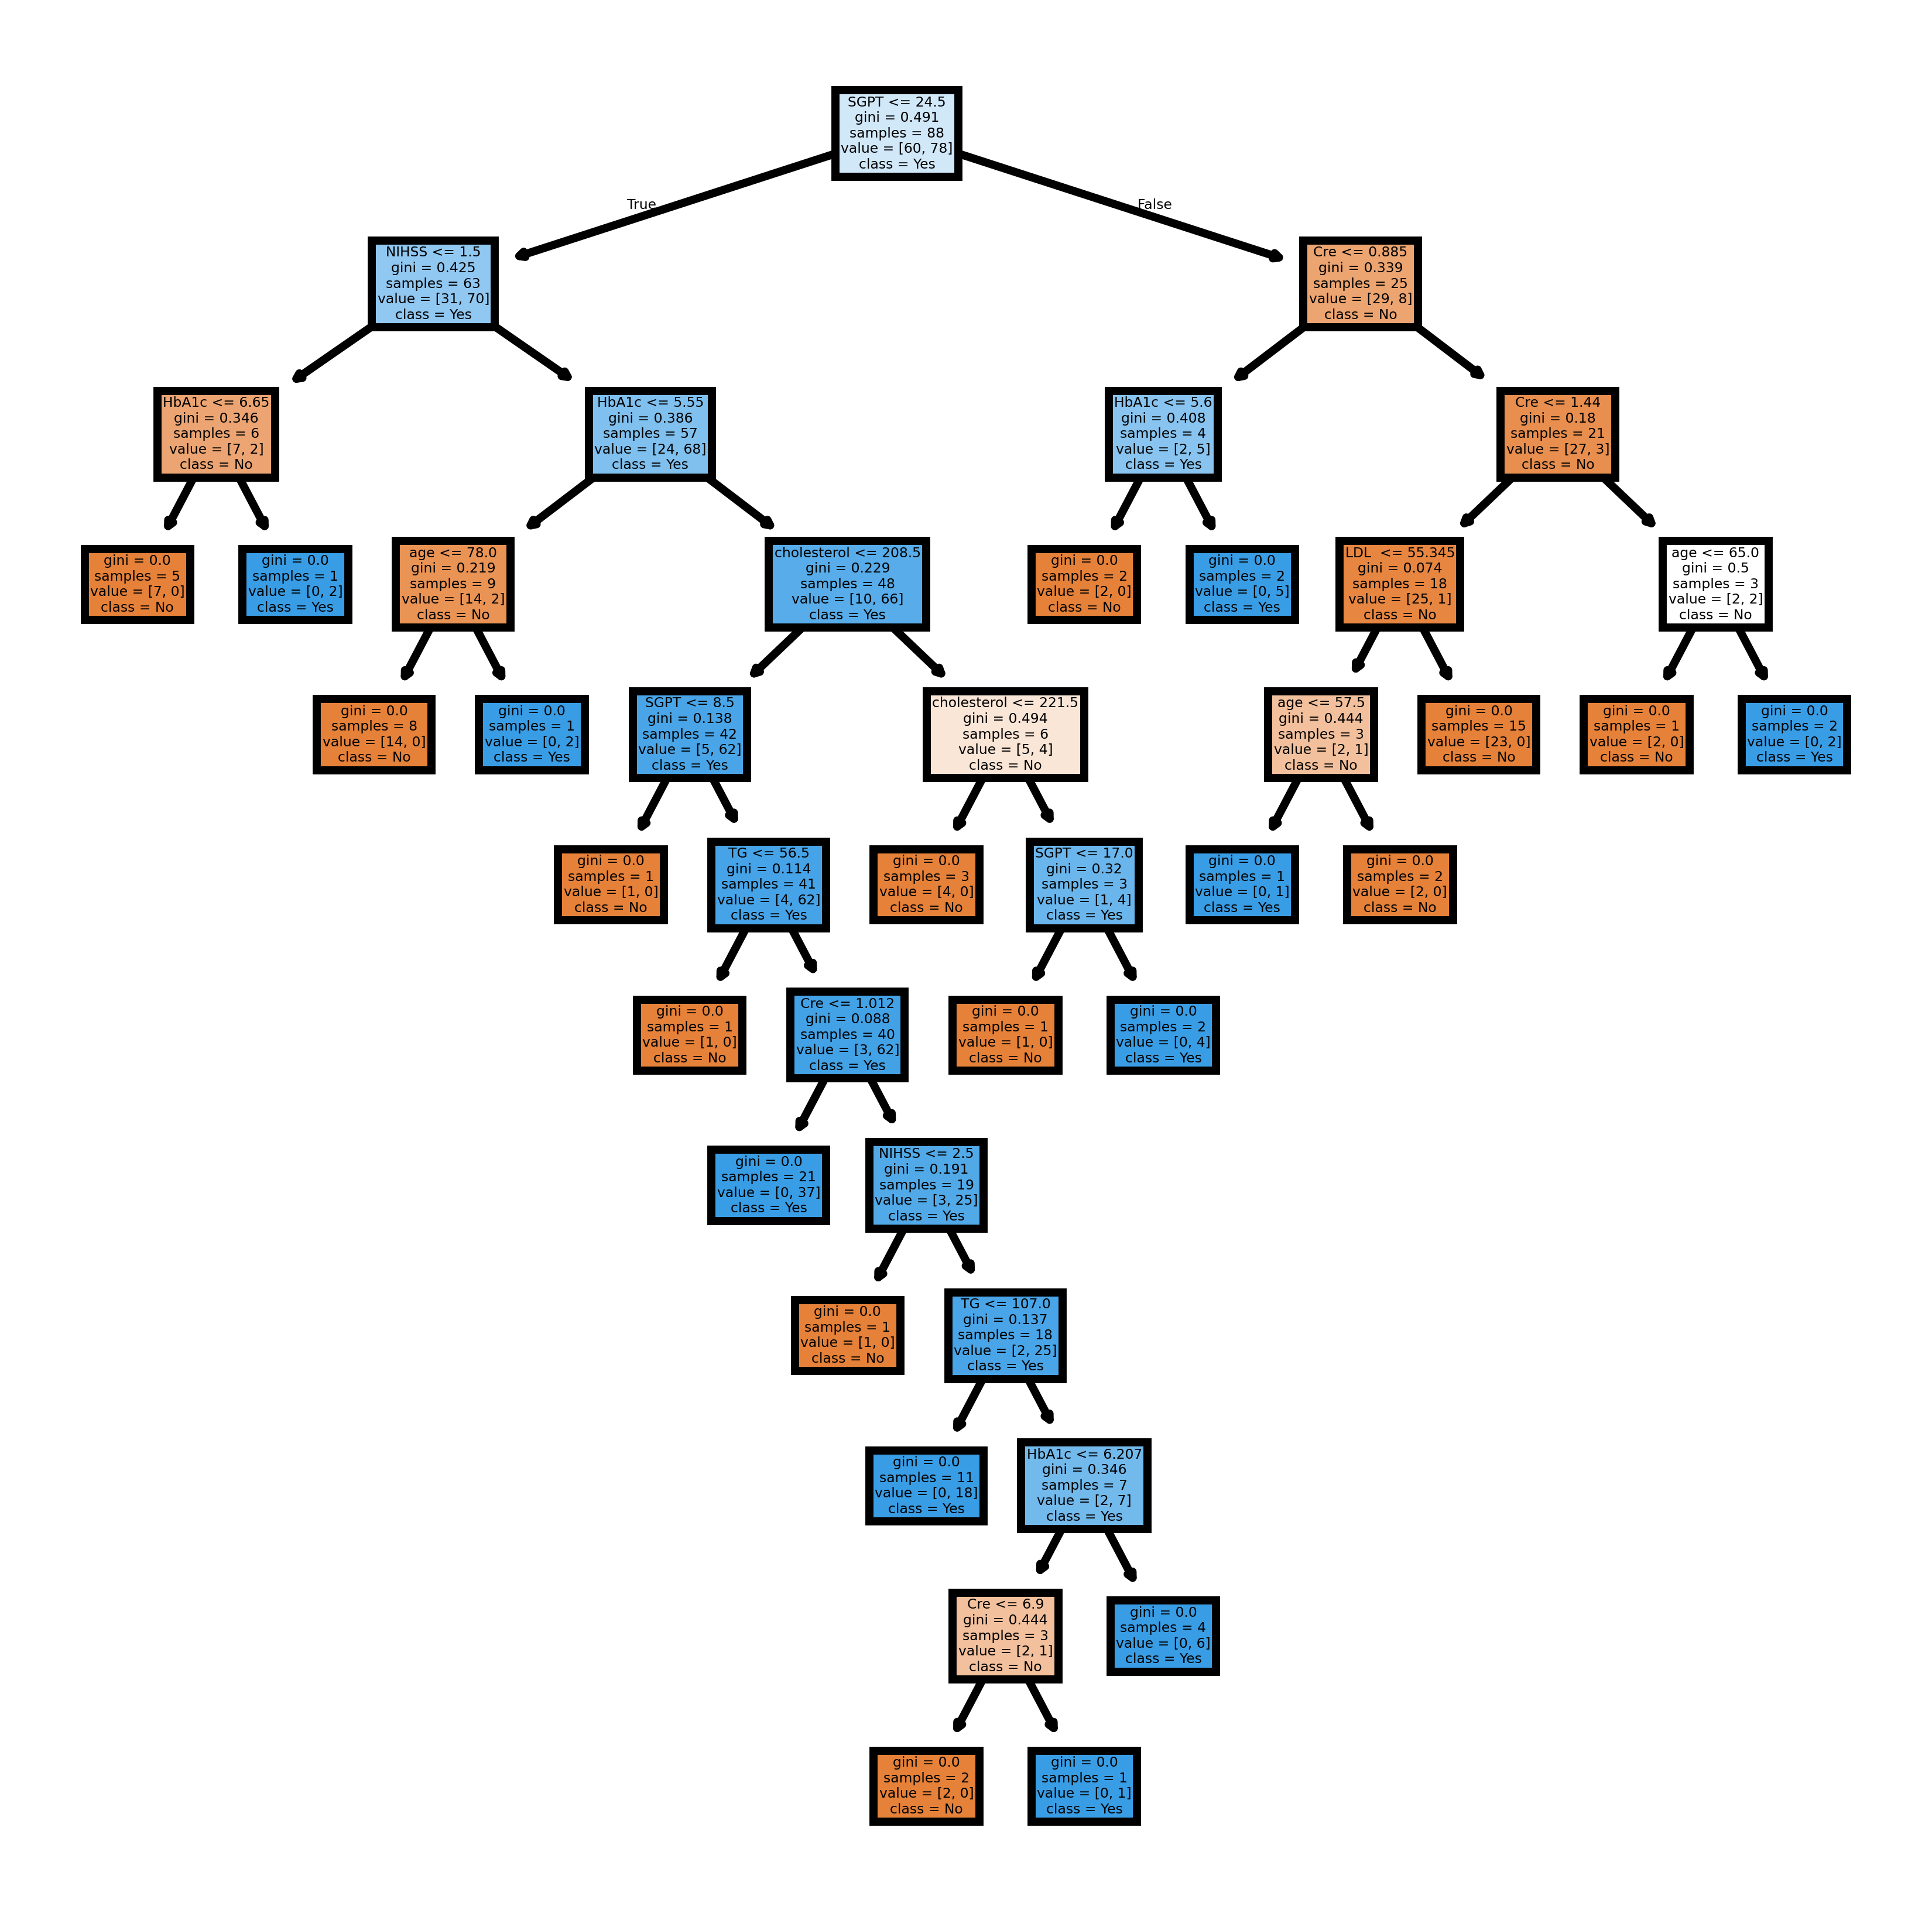

In [46]:
# 保存模型
#model_filename = path+"xgboost_model.model"
#xgboostModel.save_model(model_filename)
#print(f"模型已保存为 {model_filename}")# 視覺化
from sklearn.tree import export_graphviz
#forest.classes_ = ['0','1']
#export_graphviz(forest, out_file=path+'decisiontree.dot',
                #feature_names=['I','S','N','T','CDR'],
                #class_names=forest.classes_)
fn=['age', 'NIHSS',
       'LDL ', 'cholesterol', 'TG', 'Cre', 'SGPT', 'HbA1c', 'MRS']
cn=[ 'No','Yes']

for index in range(0,5):
    fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=1000)
    tree.plot_tree(forest.estimators_[index],
               feature_names = fn, 
               class_names=cn,
               filled = True);
fig.savefig(path+'Random Tree.png')


### XGBoost

In [48]:
from xgboost import XGBClassifier

# 建立 XGBClassifier 模型
xgboostModel = XGBClassifier(n_estimators=300, learning_rate= 0.1)
# 使用訓練資料訓練模型
xgboostModel.fit(train_X, train_y)
# 使用訓練資料預測分類
xgboost_train_predicted = xgboostModel.predict(train_X)
xgboost_test_predicted = xgboostModel.predict(test_X)

xgboost_train_predicted_pro = xgboostModel.predict_proba(train_X)
xgboost_test_predicted_pro = xgboostModel.predict_proba(test_X)

print('訓練集: ',xgboostModel.score(train_X,train_y))
print('測試集: ',xgboostModel.score(test_X,test_y))


訓練集:  1.0
測試集:  0.8611111111111112


In [49]:
#pip install xgboost

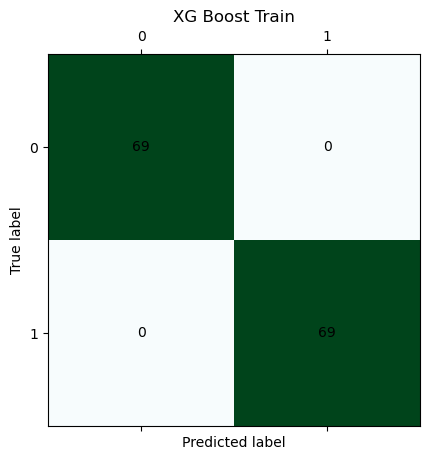

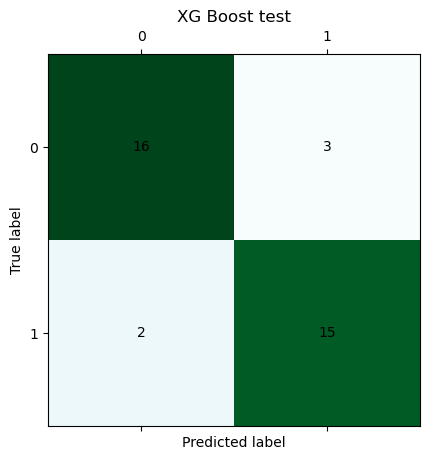

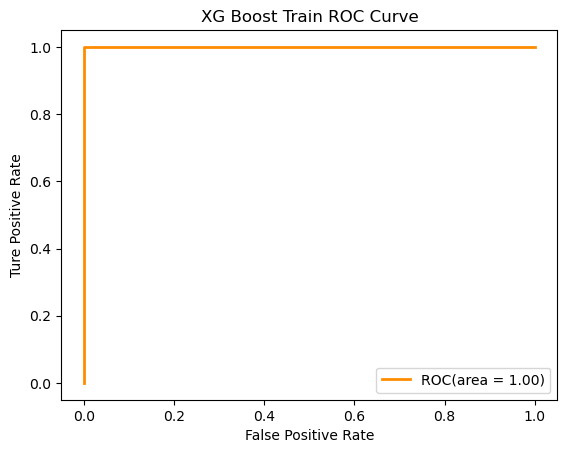

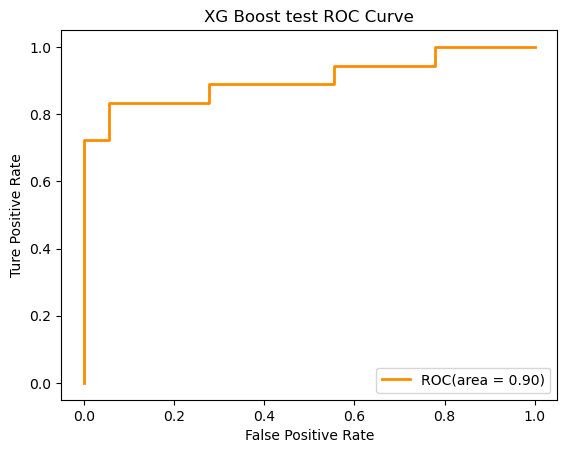

In [50]:
train_title ='XG Boost Train'
test_title ='XG Boost test'
ConfusionMatrix(train_y,xgboost_train_predicted,train_title)
ConfusionMatrix(test_y,xgboost_test_predicted,test_title)
train_auc9,fpr_train9, tpr_train9 = plot_ROC_Curve(train_y,xgboost_train_predicted_pro[:,1],train_title)
test_auc9 ,fpr_test9, tpr_test9 = plot_ROC_Curve(test_y,xgboost_test_predicted_pro[:,1],test_title)

In [51]:
name = 'XGBoost'

train_df = train_result(xgboost_train_predicted ,name,train_auc9)
test_df = test_result(xgboost_test_predicted ,name,test_auc9)

In [52]:
crossvalidation(xgboostModel,name)

Model name  dataset  accuracy_mean  accuracy_std  precision_mean  \
0     SVM Linear  10-fold       0.493464      0.113007        0.483601   
1       SVM Poly  10-fold       0.603922      0.093578        0.571934   
2        SVM RBF  10-fold       0.568954      0.105056        0.551974   
3  Decision Tree  10-fold       0.718954      0.079049        0.741207   
4  Random Forest  10-fold       0.799020      0.053549        0.788611   
5        XGBoost  10-fold       0.810784      0.105877        0.820942   

   precision_std  recall_mean  recall_std  f1-score_mean  f1-score_std  \
0       0.120401     0.556944    0.285874       0.493127      0.179614   
1       0.064848     0.862500    0.125505       0.684497      0.074698   
2       0.077929     0.758333    0.160935       0.634079      0.094698   
3       0.125005     0.719444    0.188034       0.711183      0.103066   
4       0.097398     0.843056    0.118946       0.806014      0.057160   
5       0.130083     0.819444    0.141791       0.811450      0.104153   

   auc_mean   auc_std  
0  0.525154  0.119029  
1  0.614043  0.127838  
2  0.604012  0.137347  
3  0.727778  0.082675  
4  0.899228  0.044281  
5  0.887346  0.069305

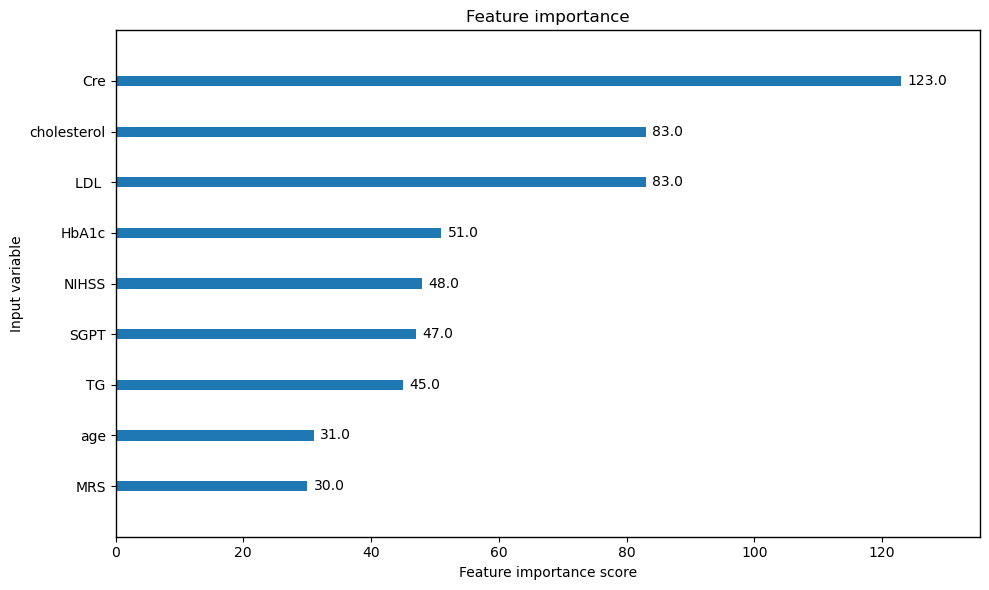

In [53]:
import matplotlib.pyplot as plt
import xgboost as xgb
import textwrap

# 初始化XGBClassifier模型
xgboostModel = xgb.XGBClassifier(n_estimators=300,
                                 booster='gbtree',
                                 learning_rate=0.1,
                                 max_depth=7,
                                 min_child_weight=5,
                                 gamma=0.0,
                                 subsample=0.9,
                                 colsample_bytree=0.8,
                                 objective='reg:logistic',
                                 tree_method='hist',
                                 reg_alpha=0.0,
                                 reg_lambda=1.0,
                                 eval_metric='auc',
                                 nthread=2,
                                 random_state=0,
                                 scale_pos_weight=1,
                                 seed=0)

# 訓練XGBoost模型
xgboostModel.fit(train_X, train_y)

# 使用plot_importance函數顯示特徵重要性圖表
plt.figure(figsize=(10, 6))
ax=xgb.plot_importance(xgboostModel, importance_type='weight', show_values=True, ax=plt.gca())
#plt.title("Feature Importance (XGBoost)")
plt.xlabel("Feature importance score")
plt.ylabel("Input variable")
plt.grid(False)

# 調整圖表邊框大小
for spine in plt.gca().spines.values():
    spine.set_linewidth(1)  # 設置邊框寬度為2個單位

    
plt.tight_layout()
plt.show()


In [54]:
# 保存模型
#model_filename = path+"xgboost_model.model"
#xgboostModel.save_model(model_filename)
#print(f"模型已保存为 {model_filename}")

### AdaBoost

In [55]:
from sklearn.ensemble import AdaBoostClassifier

adaModel = AdaBoostClassifier(n_estimators = 300)
adaModel.fit(train_X,train_y)

ada_train_predicted = adaModel.predict(train_X)
ada_test_predicted = adaModel.predict(test_X)

ada_train_predicted_pro = adaModel.predict_proba(train_X)
ada_test_predicted_pro = adaModel.predict_proba(test_X)

print("訓練集 Score: ", adaModel.score(train_X,train_y))
print("測試集 Score: ", adaModel.score(test_X,test_y))


C:\Users\Huici\.conda\envs\py310_env\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


訓練集 Score:  0.9927536231884058
測試集 Score:  0.8611111111111112


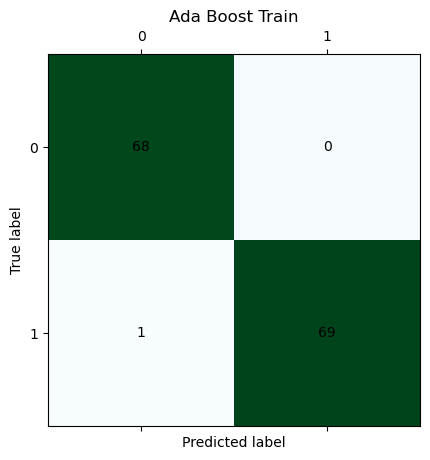

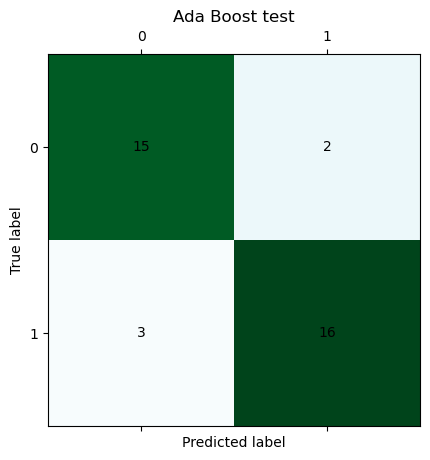

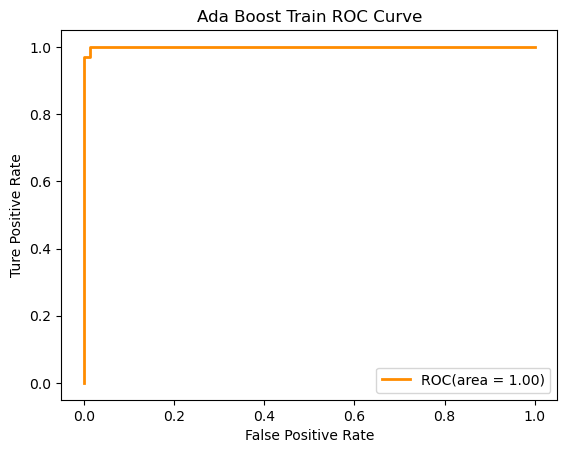

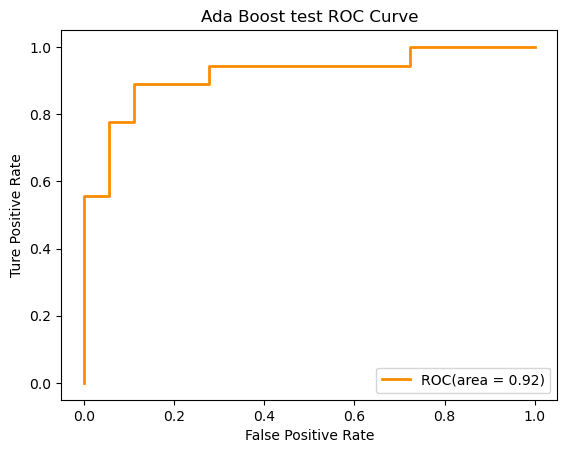

In [56]:
train_title ='Ada Boost Train'
test_title ='Ada Boost test'
ConfusionMatrix(train_y,ada_train_predicted,train_title)
ConfusionMatrix(test_y,ada_test_predicted,test_title)
train_auc10,fpr_train10, tpr_train10 = plot_ROC_Curve(train_y,ada_train_predicted_pro[:,1],train_title)
test_auc10,fpr_test10, tpr_test10 = plot_ROC_Curve(test_y,ada_test_predicted_pro[:,1],test_title)

In [57]:
name = 'AdaBoost'

train_df = train_result(ada_train_predicted ,name,train_auc10)
test_df = test_result(ada_test_predicted ,name,test_auc10)

In [58]:
crossvalidation(adaModel,name)

C:\Users\Huici\.conda\envs\py310_env\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Huici\.conda\envs\py310_env\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Huici\.conda\envs\py310_env\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Huici\.conda\envs\py310_env\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expec

Model name  dataset  accuracy_mean  accuracy_std  precision_mean  \
0     SVM Linear  10-fold       0.493464      0.113007        0.483601   
1       SVM Poly  10-fold       0.603922      0.093578        0.571934   
2        SVM RBF  10-fold       0.568954      0.105056        0.551974   
3  Decision Tree  10-fold       0.718954      0.079049        0.741207   
4  Random Forest  10-fold       0.799020      0.053549        0.788611   
5        XGBoost  10-fold       0.810784      0.105877        0.820942   
6       AdaBoost  10-fold       0.804902      0.082818        0.801064   

   precision_std  recall_mean  recall_std  f1-score_mean  f1-score_std  \
0       0.120401     0.556944    0.285874       0.493127      0.179614   
1       0.064848     0.862500    0.125505       0.684497      0.074698   
2       0.077929     0.758333    0.160935       0.634079      0.094698   
3       0.125005     0.719444    0.188034       0.711183      0.103066   
4       0.097398     0.843056    0.118946       0.806014      0.057160   
5       0.130083     0.819444    0.141791       0.811450      0.104153   
6       0.089240     0.833333    0.167692       0.805637      0.090791   

   auc_mean   auc_std  
0  0.525154  0.119029  
1  0.614043  0.127838  
2  0.604012  0.137347  
3  0.727778  0.082675  
4  0.899228  0.044281  
5  0.887346  0.069305  
6  0.882870  0.070081

C:\Users\Huici\.conda\envs\py310_env\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


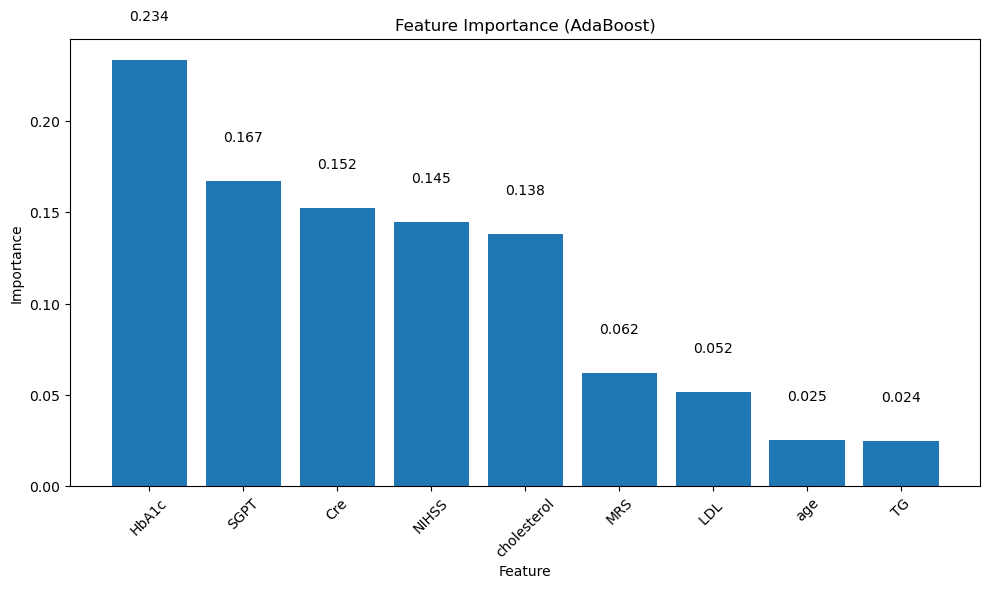

In [59]:
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier

# 使用訓練好的 AdaBoost 模型
adaboost = AdaBoostClassifier(n_estimators=50, random_state=0)
adaboost.fit(train_X, train_y)

# 獲取特徵重要性
importances = adaboost.feature_importances_

# 獲取特徵名稱
feature_names = train_X.columns

# 將特徵重要性進行排序
indices = np.argsort(importances)[::-1]

# 畫出特徵重要性圖表
plt.figure(figsize=(10, 6))
bars = plt.bar(range(train_X.shape[1]), importances[indices], align="center")
plt.xticks(range(train_X.shape[1]), feature_names[indices], rotation=45)
plt.title("Feature Importance (AdaBoost)")
plt.xlabel("Feature")
plt.ylabel("Importance")

# 在每個條形上標示特徵重要值數字
for bar, importance in zip(bars, importances[indices]):
    yval = round(importance, 3)
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, yval, ha='center', va='bottom')

plt.tight_layout()
plt.show()


### GradientBoost

In [60]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# Assuming train_X, train_y, test_X, test_y are your training and testing data

# Initialize and train GradientBoostingClassifier
gbModel = GradientBoostingClassifier(n_estimators=100, random_state=0)
gbModel.fit(train_X, train_y)

# Make predictions
gb_train_predicted = gbModel.predict(train_X)
gb_test_predicted = gbModel.predict(test_X)

# predict_proba for class probabilities
gb_train_predicted_pro = gbModel.predict_proba(train_X)
gb_test_predicted_pro = gbModel.predict_proba(test_X)

# Print scores
print("Training Set Score:", accuracy_score(train_y, gb_train_predicted))
print("Testing Set Score:", accuracy_score(test_y, gb_test_predicted))


Training Set Score: 1.0
Testing Set Score: 0.7222222222222222


C:\Users\Huici\.conda\envs\py310_env\lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


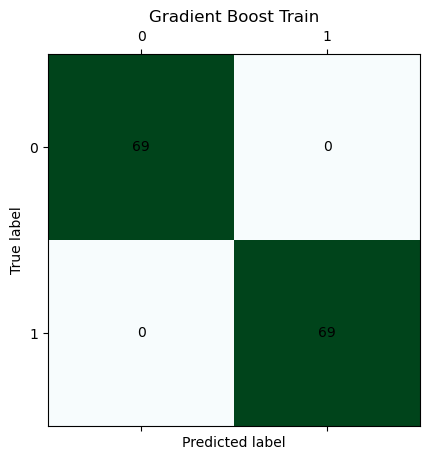

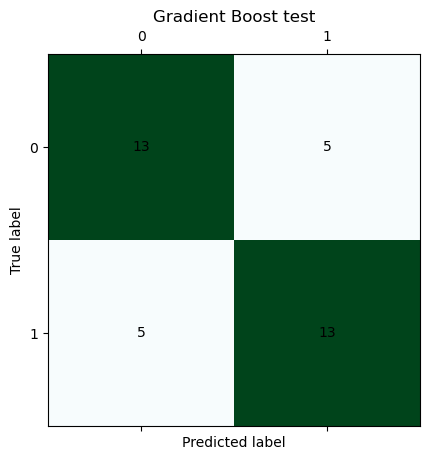

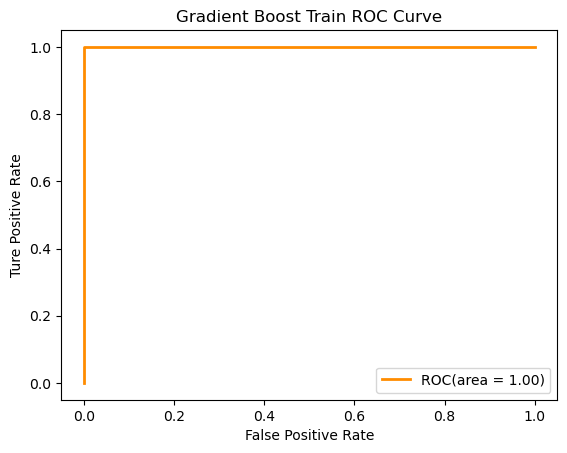

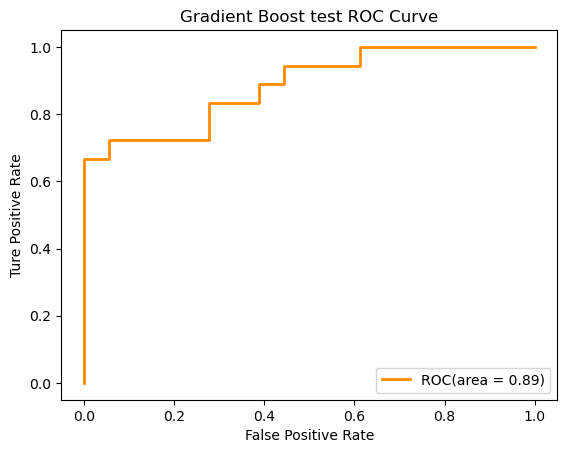

In [61]:
train_title ='Gradient Boost Train'
test_title ='Gradient Boost test'
ConfusionMatrix(train_y,gb_train_predicted,train_title)
ConfusionMatrix(test_y,gb_test_predicted,test_title)
train_auc10,fpr_train10, tpr_train10 = plot_ROC_Curve(train_y,gb_train_predicted_pro[:,1],train_title)
test_auc10,fpr_test10, tpr_test10 = plot_ROC_Curve(test_y,gb_test_predicted_pro[:,1],test_title)

In [62]:
name = 'GradientBoost'

train_df = train_result(gb_train_predicted ,name,train_auc10)
test_df = test_result(gb_test_predicted ,name,test_auc10)

In [63]:
crossvalidation(gbModel,name)

C:\Users\Huici\.conda\envs\py310_env\lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Huici\.conda\envs\py310_env\lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Huici\.conda\envs\py310_env\lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Huici\.conda\envs\py310_env\lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d arr

Model name  dataset  accuracy_mean  accuracy_std  precision_mean  \
0     SVM Linear  10-fold       0.493464      0.113007        0.483601   
1       SVM Poly  10-fold       0.603922      0.093578        0.571934   
2        SVM RBF  10-fold       0.568954      0.105056        0.551974   
3  Decision Tree  10-fold       0.718954      0.079049        0.741207   
4  Random Forest  10-fold       0.799020      0.053549        0.788611   
5        XGBoost  10-fold       0.810784      0.105877        0.820942   
6       AdaBoost  10-fold       0.804902      0.082818        0.801064   
7  GradientBoost  10-fold       0.804575      0.087713        0.783205   

   precision_std  recall_mean  recall_std  f1-score_mean  f1-score_std  \
0       0.120401     0.556944    0.285874       0.493127      0.179614   
1       0.064848     0.862500    0.125505       0.684497      0.074698   
2       0.077929     0.758333    0.160935       0.634079      0.094698   
3       0.125005     0.719444    0.188034       0.711183      0.103066   
4       0.097398     0.843056    0.118946       0.806014      0.057160   
5       0.130083     0.819444    0.141791       0.811450      0.104153   
6       0.089240     0.833333    0.167692       0.805637      0.090791   
7       0.113181     0.877778    0.122278       0.819304      0.080616   

   auc_mean   auc_std  
0  0.525154  0.119029  
1  0.614043  0.127838  
2  0.604012  0.137347  
3  0.727778  0.082675  
4  0.899228  0.044281  
5  0.887346  0.069305  
6  0.882870  0.070081  
7  0.896759  0.067860

C:\Users\Huici\.conda\envs\py310_env\lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


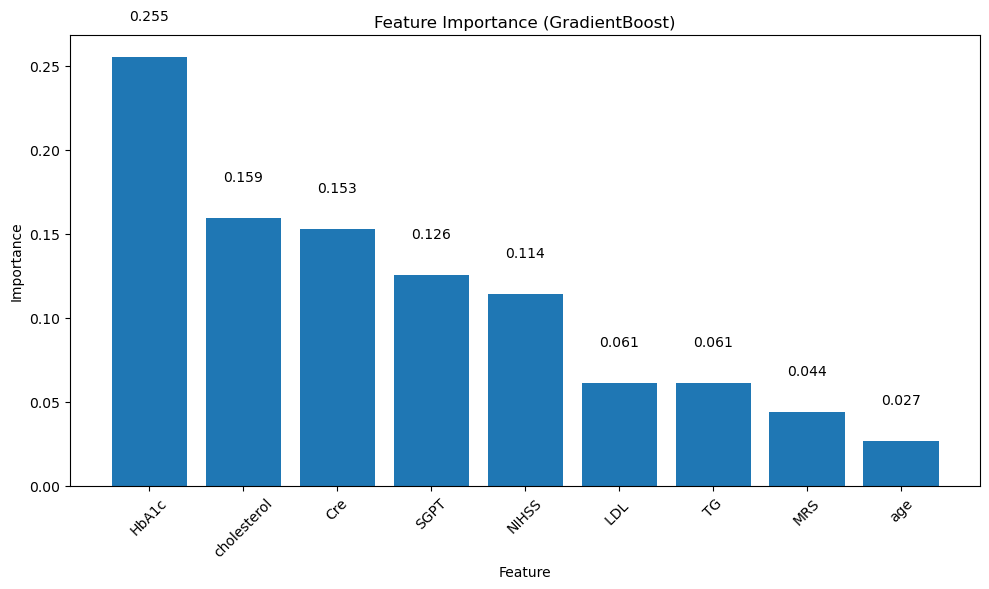

In [64]:
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier

# 使用訓練好的 AdaBoost 模型
gbModel = GradientBoostingClassifier(n_estimators=50, random_state=0)
gbModel.fit(train_X, train_y)

# 獲取特徵重要性
importances = gbModel.feature_importances_

# 獲取特徵名稱
feature_names = train_X.columns

# 將特徵重要性進行排序
indices = np.argsort(importances)[::-1]

# 畫出特徵重要性圖表
plt.figure(figsize=(10, 6))
bars = plt.bar(range(train_X.shape[1]), importances[indices], align="center")
plt.xticks(range(train_X.shape[1]), feature_names[indices], rotation=45)
plt.title("Feature Importance (GradientBoost)")
plt.xlabel("Feature")
plt.ylabel("Importance")

# 在每個條形上標示特徵重要值數字
for bar, importance in zip(bars, importances[indices]):
    yval = round(importance, 3)
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, yval, ha='center', va='bottom')

plt.tight_layout()
plt.show()

### 合併圖

In [65]:
print (train_df)

      Model name dataset  accuracy  precision  recall  f1-score   auc
0     SVM Linear   train      0.51       0.51    0.43      0.47  0.52
1       SVM Poly   train      0.61       0.58    0.80      0.67  0.64
2        SVM RBF   train      0.56       0.56    0.58      0.57  0.38
3  Decision Tree   train      1.00       1.00    1.00      1.00  1.00
4  Random Forest   train      0.96       0.93    1.00      0.97  1.00
5        XGBoost   train      1.00       1.00    1.00      1.00  1.00
6       AdaBoost   train      0.99       0.99    1.00      0.99  1.00
7  GradientBoost   train      1.00       1.00    1.00      1.00  1.00


In [66]:
print (test_df)

      Model name dataset  accuracy  precision  recall  f1-score   auc
0     SVM Linear    test      0.25       0.24    0.22      0.23  0.77
1       SVM Poly    test      0.64       0.61    0.78      0.68  0.70
2        SVM RBF    test      0.58       0.60    0.50      0.55  0.41
3  Decision Tree    test      0.75       0.76    0.72      0.74  0.75
4  Random Forest    test      0.83       0.88    0.78      0.82  0.88
5        XGBoost    test      0.86       0.88    0.83      0.86  0.90
6       AdaBoost    test      0.86       0.84    0.89      0.86  0.92
7  GradientBoost    test      0.72       0.72    0.72      0.72  0.89


In [67]:
print(ten_fold_avg_std_df)

      Model name  dataset  accuracy_mean  accuracy_std  precision_mean  \
0     SVM Linear  10-fold       0.493464      0.113007        0.483601   
1       SVM Poly  10-fold       0.603922      0.093578        0.571934   
2        SVM RBF  10-fold       0.568954      0.105056        0.551974   
3  Decision Tree  10-fold       0.718954      0.079049        0.741207   
4  Random Forest  10-fold       0.799020      0.053549        0.788611   
5        XGBoost  10-fold       0.810784      0.105877        0.820942   
6       AdaBoost  10-fold       0.804902      0.082818        0.801064   
7  GradientBoost  10-fold       0.804575      0.087713        0.783205   

   precision_std  recall_mean  recall_std  f1-score_mean  f1-score_std  \
0       0.120401     0.556944    0.285874       0.493127      0.179614   
1       0.064848     0.862500    0.125505       0.684497      0.074698   
2       0.077929     0.758333    0.160935       0.634079      0.094698   
3       0.125005     0.719444    0.18

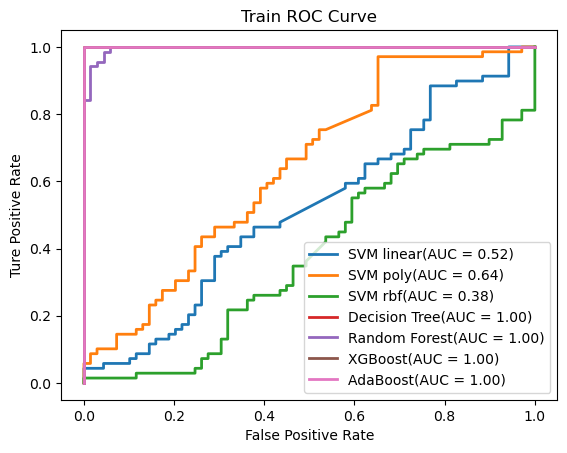

In [68]:
plt.figure(1)
plt.plot(fpr_train3, tpr_train3, label= 'SVM linear(AUC = {0:.2f})'.format(train_auc3),lw=2)
plt.plot(fpr_train4, tpr_train4, label= 'SVM poly(AUC = {0:.2f})'.format(train_auc4),lw=2)
plt.plot(fpr_train5, tpr_train5, label= 'SVM rbf(AUC = {0:.2f})'.format(train_auc5),lw=2)

plt.plot(fpr_train7, tpr_train7, label= 'Decision Tree(AUC = {0:.2f})'.format(train_auc7),lw=2)
plt.plot(fpr_train8, tpr_train8, label= 'Random Forest(AUC = {0:.2f})'.format(train_auc8),lw=2)
plt.plot(fpr_train9, tpr_train9, label= 'XGBoost(AUC = {0:.2f})'.format(train_auc9),lw=2)
plt.plot(fpr_train10, tpr_train10, label= 'AdaBoost(AUC = {0:.2f})'.format(train_auc10),lw=2)
#plt.plot(fpr_train11, tpr_train11, label= 'Stacking(AUC = {0:.2f})'.format(train_auc11),lw=2)
#plt.plot(fpr_train12, tpr_train12, label= 'LGBM(AUC = {0:.2f})'.format(train_auc12),lw=2)

plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('Ture Positive Rate')
plt.title('Train ROC Curve')
plt.legend(loc = 'lower right')
plt.savefig(path+'ROC曲線圖檔\\train roc.png', bbox_inches='tight')
plt.show()

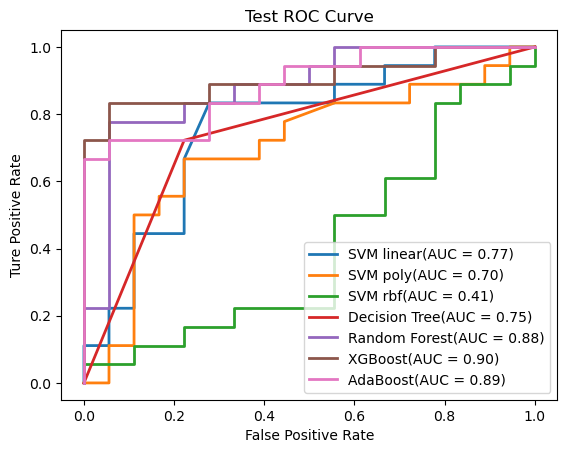

In [69]:
plt.figure(1)
plt.plot(fpr_test3, tpr_test3, label= 'SVM linear(AUC = {0:.2f})'.format(test_auc3),lw=2)
plt.plot(fpr_test4, tpr_test4, label= 'SVM poly(AUC = {0:.2f})'.format(test_auc4),lw=2)
plt.plot(fpr_test5, tpr_test5, label= 'SVM rbf(AUC = {0:.2f})'.format(test_auc5),lw=2)

plt.plot(fpr_test7, tpr_test7, label= 'Decision Tree(AUC = {0:.2f})'.format(test_auc7),lw=2)
plt.plot(fpr_test8, tpr_test8, label= 'Random Forest(AUC = {0:.2f})'.format(test_auc8),lw=2)
plt.plot(fpr_test9, tpr_test9, label= 'XGBoost(AUC = {0:.2f})'.format(test_auc9),lw=2)
plt.plot(fpr_test10, tpr_test10, label= 'AdaBoost(AUC = {0:.2f})'.format(test_auc10),lw=2)
#plt.plot(fpr_test11, tpr_test11, label= 'Stacking(AUC = {0:.2f})'.format(test_auc11),lw=2)
#plt.plot(fpr_test12, tpr_test12, label= 'LGBM(AUC = {0:.2f})'.format(test_auc12),lw=2)

plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('Ture Positive Rate')
plt.title('Test ROC Curve')
plt.legend(loc = 'lower right')
plt.savefig(path+'ROC曲線圖檔\\test roc.png', bbox_inches='tight')
plt.show()